# 0.0 IMPORTS


In [2]:
from IPython.core.display  import HTML
from IPython.display       import Image
from tabulate              import tabulate
from sklearn.preprocessing import RobustScaler, MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from matplotlib            import pyplot  as plt
from scipy                 import stats   as ss
from boruta                import BorutaPy
from sklearn.ensemble      import ExtraTreesRegressor
from sklearn.linear_model  import LinearRegression,Lasso
from sklearn.metrics       import mean_absolute_error, mean_squared_error
from sklearn.ensemble      import RandomForestRegressor

import pandas  as pd
import numpy   as np
import seaborn as sns
import xgboost as xgb
import math
import inflection
import datetime
import random
import pickle



## 0.1 Helper Functions

In [3]:
def cross_validation(x_training,kfold,model_name, model,verbose=False):
    mae_list = []
    mape_list = []
    rmse_list = []

    for k in reversed(range(1,kfold + 1)):
        if verbose:
            print('\nKFold Number:{}'.format(k))
        #start and end date for validation
        validation_start_date = x_training['date'].max() - datetime.timedelta(weeks=k*6)
        validation_end_date = x_training['date'].max() - datetime.timedelta(weeks=k*0)

        #filtering dataset
        training = x_training[x_training['date'] < validation_start_date]
        validation = x_training[(x_training['date'] >= validation_start_date) & (x_training['date'] <= validation_end_date)]

        #training and validation dataset
        
        #training
        xtraining = training.drop(['date','sales'], axis=1)
        ytraining = training['sales']

        #validation
        xvalidation = validation.drop(['date','sales'], axis=1)
        yvalidation = validation['sales']

        #model
        m = model.fit(xtraining,ytraining)

        #prediction
        yhat = m.predict(xvalidation)

        #performance
        m_result = ml_error(model_name, np.expm1(yvalidation), np.expm1(yhat))
        
        #store performance of each kfold iteration
        mae_list.append(m_result['MAE'])
        mape_list.append(m_result['MAPE'])
        rmse_list.append(m_result['RMSE'])
        
    return pd.DataFrame({'Model Name': model_name,
                         'MAE CV': np.round(np.mean(mae_list),2).astype(str) + ' +/- ' + np.round(np.std(mae_list),2).astype(str),
                         'MAPE CV':np.round(np.mean(mape_list),2).astype(str) + ' +/- ' + np.round(np.std(mape_list),2).astype(str),
                         'RSME CV': np.round(np.mean(rmse_list),2).astype(str) + ' +/- ' + np.round(np.std(rmse_list),2).astype(str)},index=[0])

def mean_absolute_percentage_error (y, yhat):
    return np.mean(np.abs((y - yhat)/ y))


def ml_error(model_name, y, yhat):
    mae = mean_absolute_error (y, yhat)
    mape = mean_absolute_percentage_error (y, yhat)
    rmse = np.sqrt(mean_squared_error(y,yhat))
    
    return pd.DataFrame({'Model Name': model_name,
                                    'MAE': mae,
                                    'MAPE': mape,
                                    'RMSE': rmse}, index=[0])

def cramer_v(x,y):
    cm = pd.crosstab(x, y).values
    n = cm.sum()
    r, k = cm.shape
    
    chi2 = ss.chi2_contingency (cm)[0]
    chi2corr = max(0,chi2 - (k-1)*(r-1)/(n-1))
    
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)

    return np.sqrt((chi2corr/n)/min(kcorr-1,rcorr-1))

def jupyter_settings():
    %matplotlib inline
    %pylab inline
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    sns.set()


In [9]:
jupyter_settings()


%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


## 0.2 Loading Data


In [4]:
df_sales_raw = pd.read_csv('data/train.csv', low_memory=False)
df_store_raw = pd.read_csv('data/store.csv', low_memory=False)

#merge
df_raw = pd.merge(df_sales_raw, df_store_raw, how='left', on='Store')

In [ ]:
df_raw.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


# 1.0 DESCRIÇÃO DOS DADOS

In [1]:
df1 = df_raw.copy()

NameError: name 'df_raw' is not defined

## 1.1 Rename Columns

In [ ]:
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo','StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
           'CompetitionDistance', 'CompetitionOpenSinceMonth','CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek','Promo2SinceYear', 'PromoInterval']

snakecase = lambda x: inflection.underscore (x)

cols_new = list(map(snakecase, cols_old))

#rename
df1.columns = cols_new

## 1.2 Data Dimensions

In [ ]:
print('Number of Rows: {}'.format(df1.shape[0]))
print('Number of Rows: {}'.format(df1.shape[1]))

Number of Rows: 1017209
Number of Rows: 18


## 1.3 Data Types

In [ ]:
df1['date'] = pd.to_datetime(df1['date'])
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

## 1.4 Check NA

In [ ]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

## 1.5 Fillout NA

In [ ]:
#competition_distance 
df1['competition_distance'] = df1['competition_distance'].fillna(200000)

#competition_open_since_month    
df1['competition_open_since_month'] = df1['competition_open_since_month'].fillna(df1['date'].dt.month)

#competition_open_since_year    
df1['competition_open_since_year'] = df1['competition_open_since_year'].fillna(df1['date'].dt.year)
                            
#promo2_since_week  
df1['promo2_since_week'] = df1['promo2_since_week'].fillna(df1['date'].dt.isocalendar().week)

#promo2_since_year 
df1['promo2_since_year'] = df1['promo2_since_year'].fillna(df1['date'].dt.year)

#promo_interval     
month_map = {1: 'Jan', 2: 'Fev', 3:'Mar', 4:'Apr', 5:'May', 6:'Jun', 7:'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'}

df1['promo_interval'] = df1['promo_interval'].fillna(0)

df1['month_map'] = df1['date'].dt.month.map(month_map)

df1['is_promo'] = df1[['promo_interval','month_map']].apply(lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split( ',' ) else 0, axis=1)

## 1.6 Change Types

In [ ]:
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype (int)
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype (int)

df1['promo2_since_week'] = df1['promo2_since_week'].astype (int)
df1['promo2_since_year'] = df1['promo2_since_year'].astype (int)

## 1.7 Descriptive Statistical

In [ ]:
num_attributes = df1.select_dtypes(include=['int64','float64'])
cat_attributes = df1.select_dtypes(exclude=['int64','float64','datetime64[ns]'])

### 1.7.1 Numerical Attributes

In [ ]:
# Central Tendency - mean, median
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T

# Dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame(num_attributes.apply(np.std)).T
d2 = pd.DataFrame(num_attributes.apply(np.min)).T
d3 = pd.DataFrame(num_attributes.apply(np.max)).T
d4 = pd.DataFrame(num_attributes.apply( lambda x: x.max() - x.min() )).T
d5 = pd.DataFrame(num_attributes.apply( lambda x: x.skew() ) ).T
d6 = pd.DataFrame(num_attributes.apply( lambda x: x.kurtosis() )).T

#concatenate
m = pd.concat([d2,d3,d4,ct1,ct2,d1,d5,d6]).T.reset_index()
m.columns = ['attributes','min','max','range','mean','median','std','skew','kurtosis']
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,200000.0,199980.0,5935.442677,2330.0,12547.646829,10.242344,147.789712
8,promo2,0.0,1.0,1.0,0.500564,1.0,0.500000,-0.002255,-1.999999
9,is_promo,0.0,1.0,1.0,0.155231,0.0,0.362124,1.904152,1.625796


### 1.7.2 Categorical Attributes

In [ ]:
cat_attributes.apply(lambda x: x.nunique())

state_holiday                    4
store_type                       4
assortment                       3
competition_open_since_month    12
competition_open_since_year     23
promo2_since_week               52
promo2_since_year                7
promo_interval                   4
month_map                       12
dtype: int64

<Axes: xlabel='assortment', ylabel='sales'>

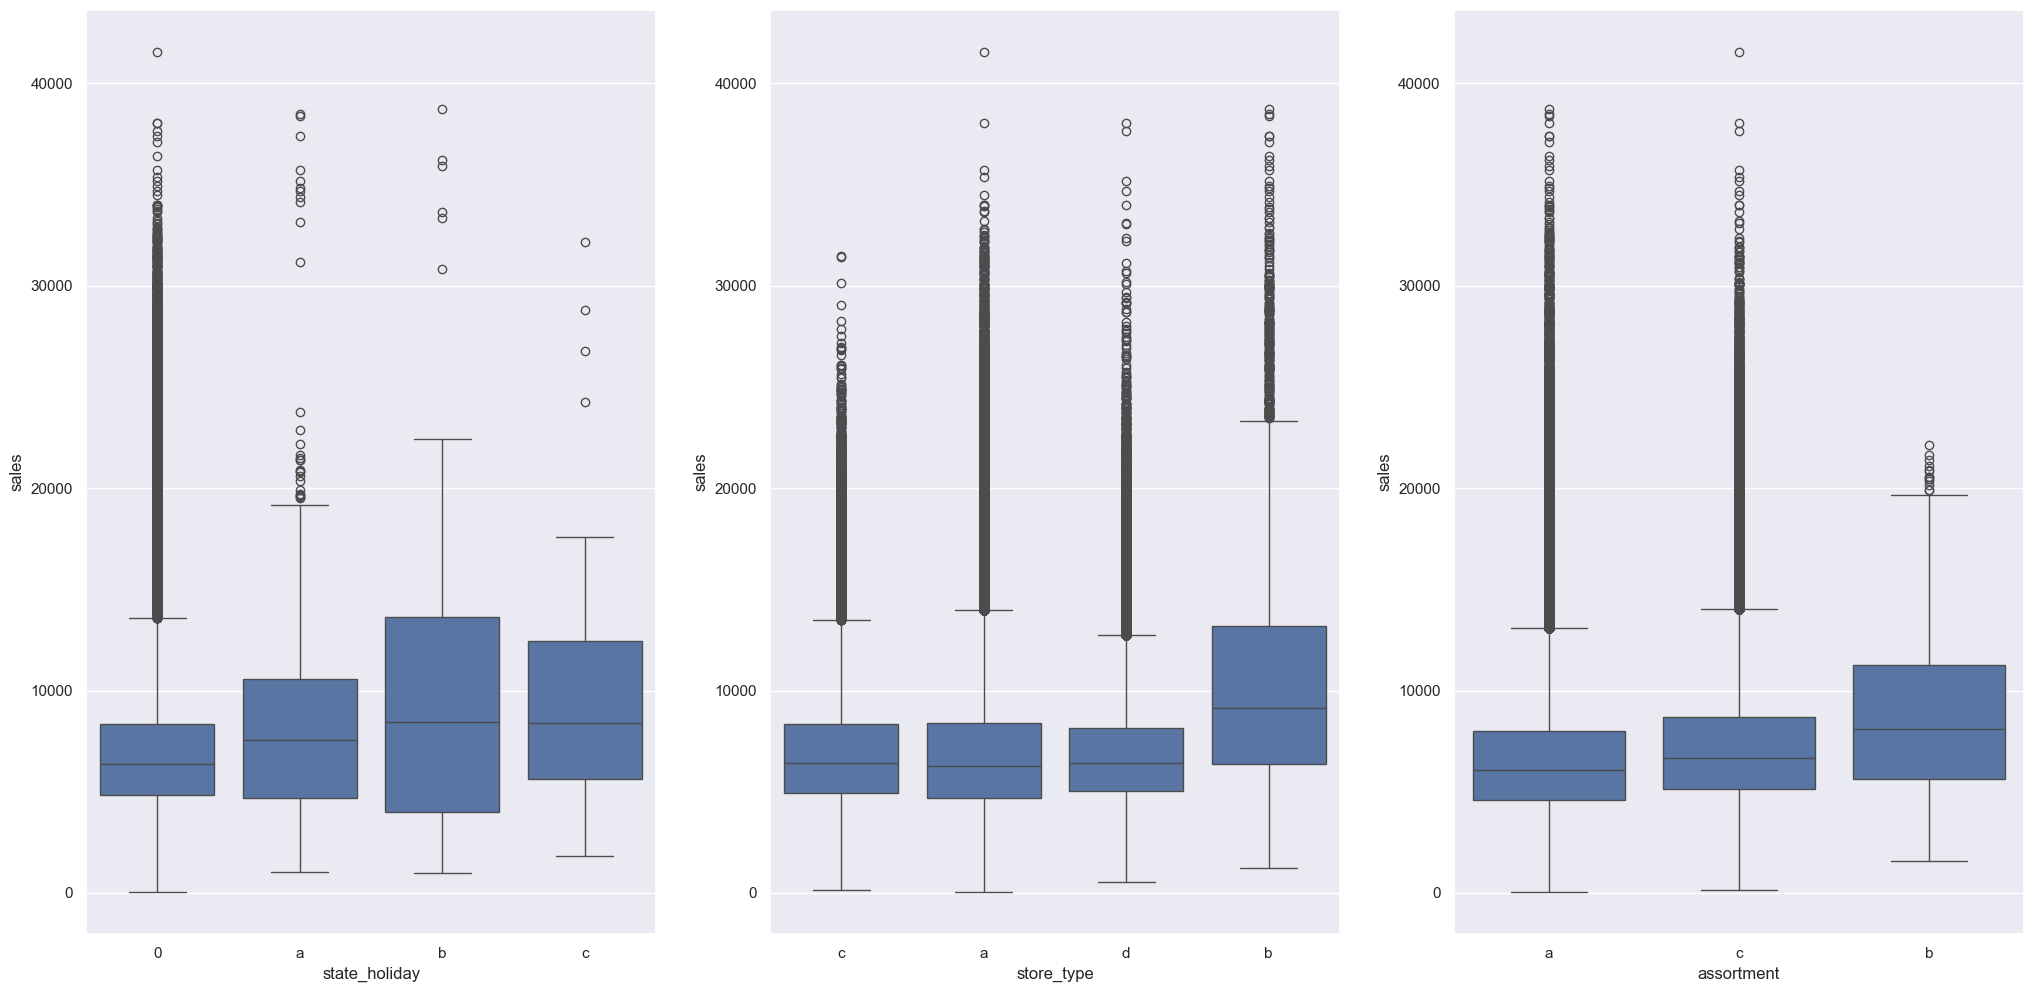

In [ ]:
aux1 = df1[(df1['state_holiday'] != 0) & (df1['sales'] > 0)]

plt.subplot(1,3,1)
sns.boxplot(x="state_holiday", y="sales", data=aux1)

plt.subplot(1,3,2)
sns.boxplot(x="store_type", y="sales", data=aux1)

plt.subplot(1,3,3)
sns.boxplot(x="assortment", y="sales", data=aux1)


# 2.0 FEATURE ENGINEERING

In [ ]:
df2 = df1.copy()

## 2.1 Mapa Mental de Hipóteses

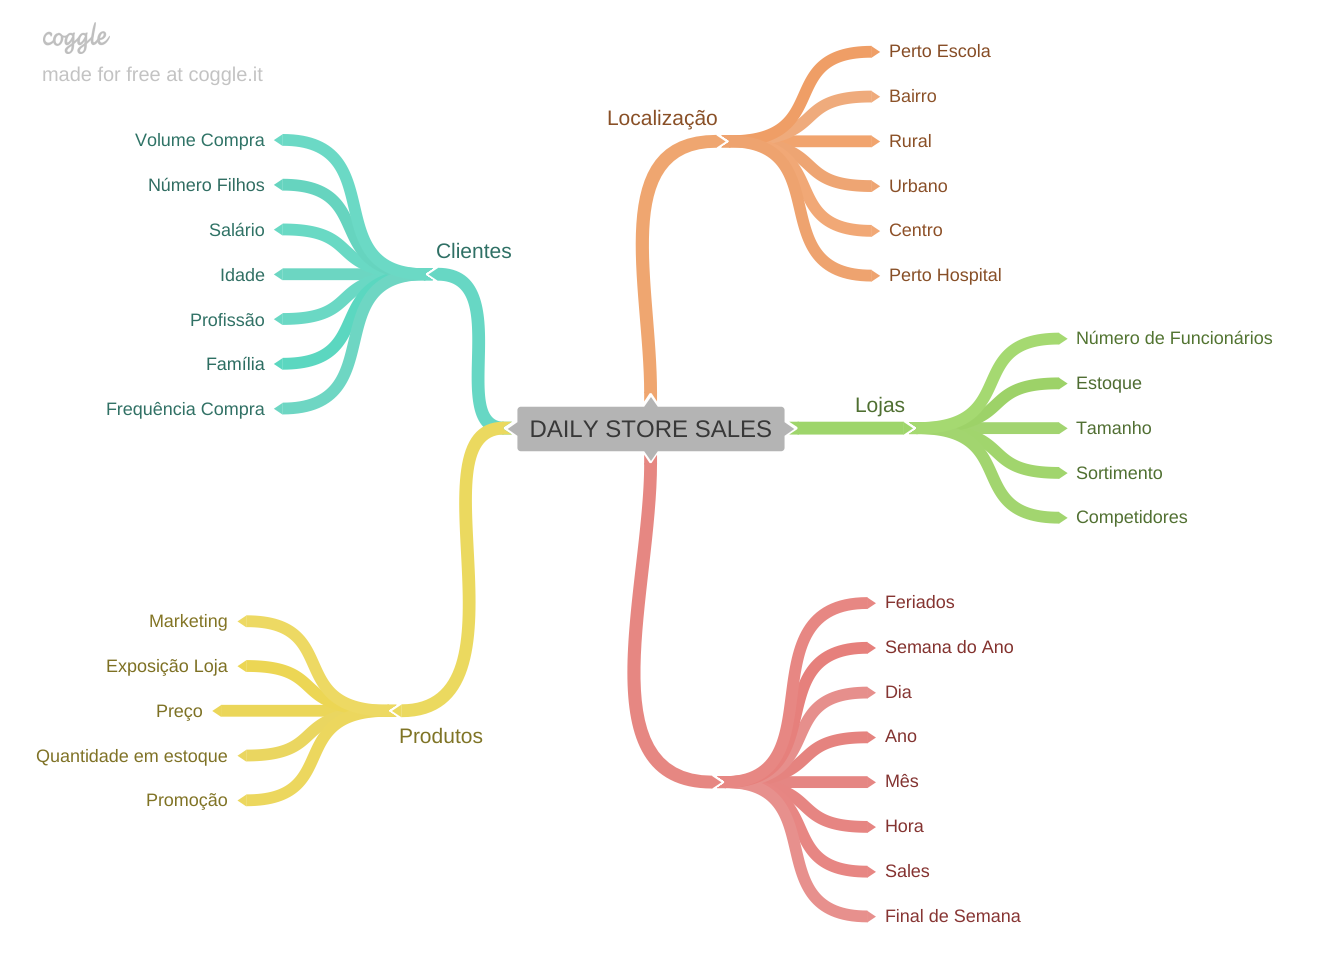

In [ ]:
Image('img/MindMapHypothesis.png')

## 2.2 Criação das Hipóteses

### 2.2.1 Hipóteses Loja

**1.** Lojas com maior quadro de funcionários deveriam vender mais.

**2.** Lojas com maior estoque deveriam vender mais.

**3.** Lojas com maior porte deveriam vender mais.

**4.** Lojas com menor porte deveriam vender menos.

**5.** Lojas com maior sortimento deveriam vender mais.

### 2.2.2 Hipóteses Produto

**1.** Lojas que investem mais em marketing deveriam vender mais.

**2.** Lojas que expoem mais o produto nas vitrines deveriam vender mais.

**3.** Lojas que tem preços menores nos produtos deveriam vender mais.

**4.** Lojas que tem preços menores  por mais tempo nos produtos deveriam vender mais.

### 2.2.3 Hipóteses Tempo

**1.** Lojas que tem mais feriados deveriam vender menos.

**2.** Lojas que abrem nos primeiros 6 meses deveriam vender mais.

**3.** Lojas que abrem nos finais de semana deveriam vender mais.

## 2.3 Lista Final de Hipóteses

**1.** Lojas com maior sortimentos deveriam vender mais.
    
**2.** Lojas com competidores mais próximos deveriam vender menos.

**3.** Lojas com competidores a mais tempo deveriam vender mais.

**4.** Lojas com promoções ativas por mais tempo deveriam vender mais.

**5.** Lojas com mais dias de promoção deveriam vender mais.

**6.** Lojas com mais promoções consecutivas deveriam vender mais.

**7.** Lojas abertas durante feriado de Natal deveriam vender mais.

**8.** Lojas deveriam vender mais ao longo dos anos.

**9.** Lojas deveriam vender mais no segundo semestre do ano.

**10.** Lojas deveriam vender mais depois do dia 10 de cada mês.

**11.** Lojas deveriam vender menos aos finais de semana.

**12.** Lojas deveriam vender menos durante os feriados escolares.

## 2.4 Feature Engineering

In [ ]:
# year
df2['year'] = df2['date'].dt.year
# month
df2['month'] = df2['date'].dt.month
# day
df2['day'] = df2['date'].dt.day
# week of year
df2['week_of_year'] = df2['date'].dt.isocalendar().week
# year week
df2['year_week'] = df2['date'].dt.strftime('%Y-%W')

# competition since
df2['competition_since'] = df2.apply(lambda x: datetime.datetime(year=x['competition_open_since_year'], month=x['competition_open_since_month'], day=1), axis=1)
df2['competition_time_month'] = ((df2['date'] - df2['competition_since'])/30).apply(lambda x: x.days).astype(int)

# promo since
df2['promo_since'] = df2['promo2_since_year'].astype(str) + '-' + df2['promo2_since_week'].astype(str)
df2['promo_since'] = df2['promo_since'].apply( lambda x: datetime.datetime.strptime( x + '-1', '%Y-%W-%w' ) - datetime.timedelta( days=7 ) )
df2['promo_time_week'] = ( ( df2['date'] - df2['promo_since'] )/7 ).apply(lambda x: x.days ).astype( int )

# assortment
df2['assortment'] = df2['assortment'].apply( lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended' )

# state holiday
df2['state_holiday'] = df2['state_holiday'].apply( lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day' )


In [ ]:
df2.head().T

,0,1,2,3,4
store,1,2,3,4,5
day_of_week,5,5,5,5,5
date,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00
sales,5263,6064,8314,13995,4822
customers,555,625,821,1498,559
open,1,1,1,1,1
promo,1,1,1,1,1
state_holiday,regular_day,regular_day,regular_day,regular_day,regular_day
school_holiday,1,1,1,1,1
store_type,c,a,a,c,a


# 3.0 FILTRAGEM DE VARIÁVEIS

In [ ]:
df3 = df2.copy()

## 3.1 Filtragem das Linhas

In [ ]:
df3 = df3[(df3['open'] != 0) & (df3['sales'] > 0)]

## 3.2 Seleção das Colunas

In [ ]:
cols_drop = ['customers','open', 'promo_interval', 'month_map']
df3 = df3.drop(cols_drop, axis=1)

# 4.0 ANÁLISE EXPLORATÓRIA DOS DADOS

In [ ]:
df4 = df3.copy()

## 4.1 Análise Univariada

### 4.1.1 Response Variable

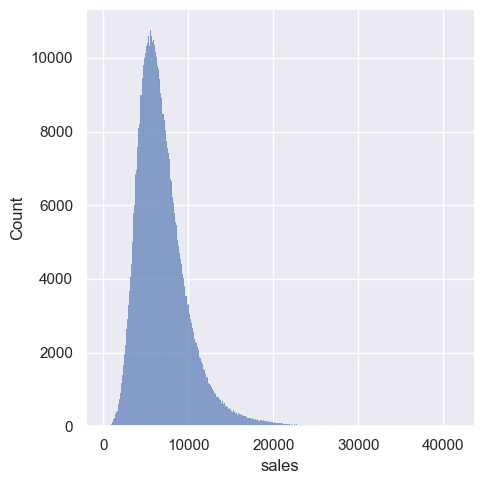

In [ ]:
sns.displot(df4['sales'])

### 4.1.2 Numerical Variable

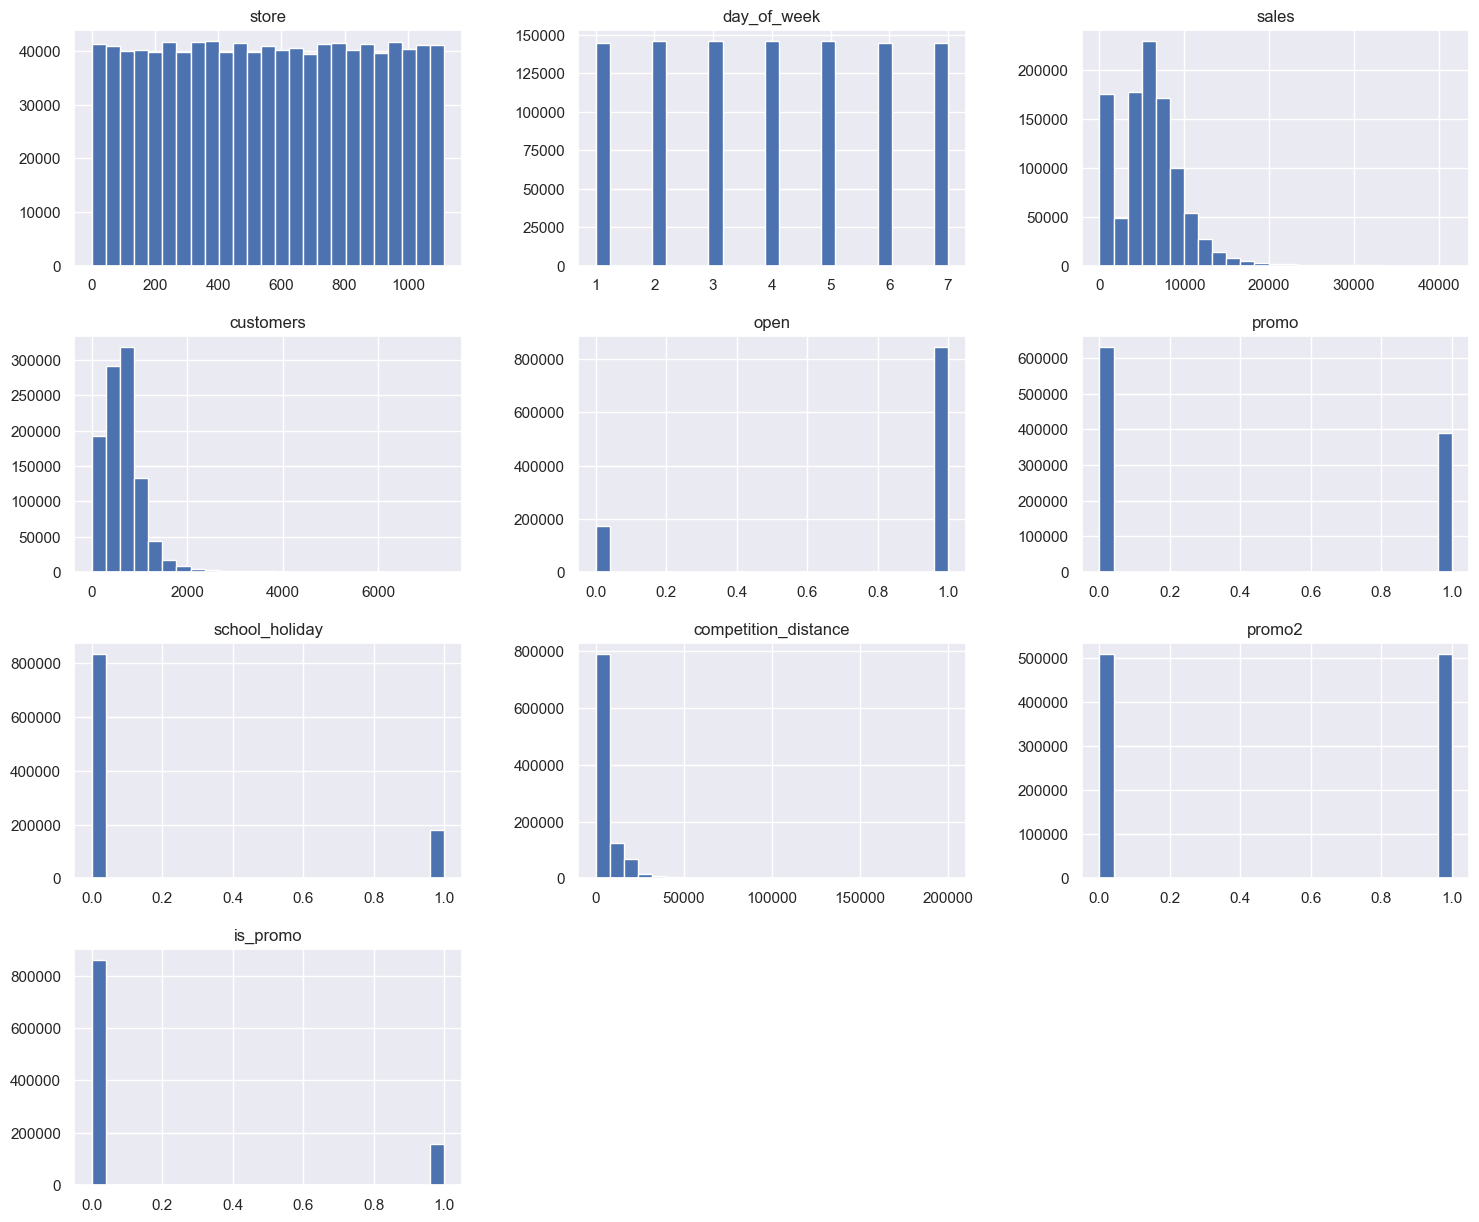

In [ ]:
num_attributes.hist(bins=25, figsize=(18, 15));

### 4.1.3 Categorical Variable

<Axes: xlabel='sales', ylabel='Density'>

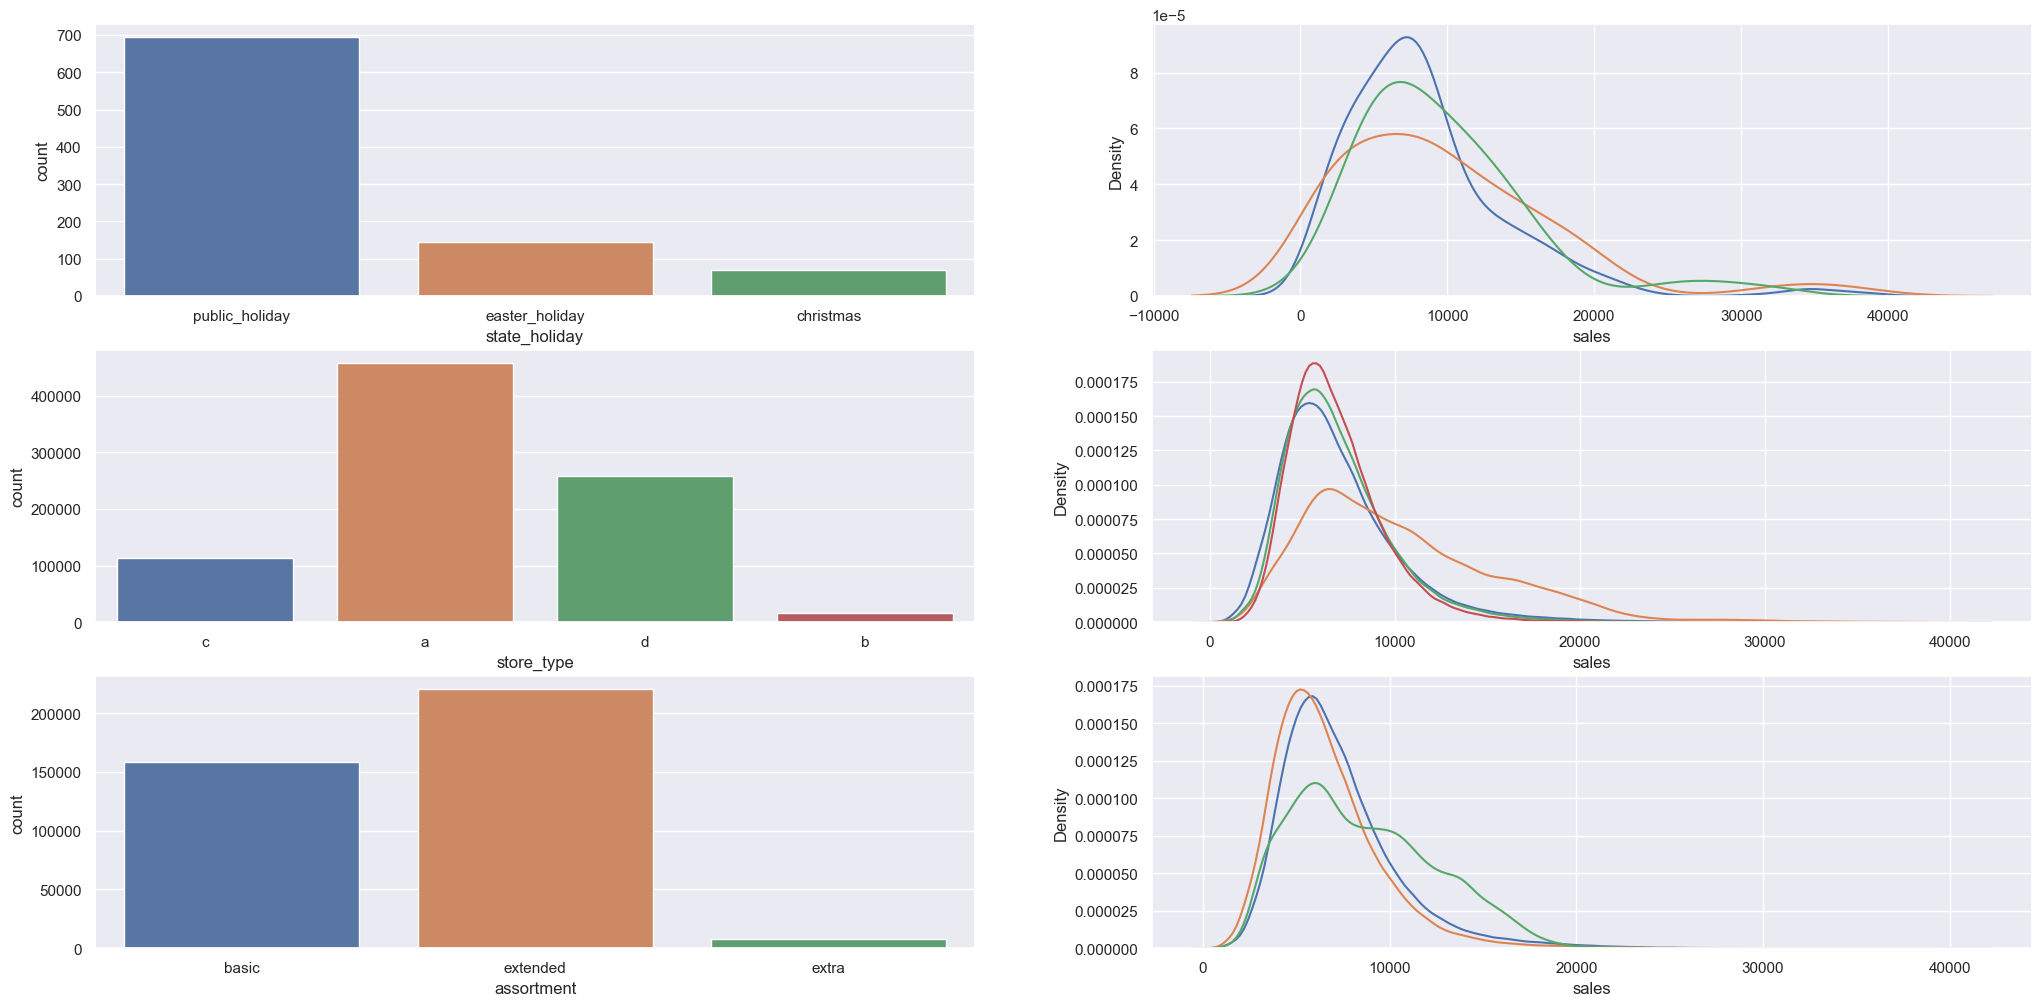

In [ ]:
#plt.figure(figsize=(14, 7))

#state_holiday

plt.subplot(3,2,1)
a = df4[df4['state_holiday'] != 'regular_day']
sns.countplot(x="state_holiday",hue="state_holiday",data=a)

plt.subplot(3,2,2)
sns.kdeplot(df4[df4['state_holiday'] == 'public_holiday']['sales'], label='public_holiday')
sns.kdeplot(df4[df4['state_holiday'] == 'easter_holiday']['sales'], label='easter_holiday')
sns.kdeplot(df4[df4['state_holiday'] == 'christmas']['sales'], label='christmas')

#store_type

plt.subplot(3,2,3)
aa = df4[df4['store_type'] != 'na']
sns.countplot(x="store_type",hue="store_type",data=aa)

plt.subplot(3,2,4)
sns.kdeplot(df4[df4['store_type'] == 'a']['sales'], label='a')
sns.kdeplot(df4[df4['store_type'] == 'b']['sales'], label='b')
sns.kdeplot(df4[df4['store_type'] == 'c']['sales'], label='c')
sns.kdeplot(df4[df4['store_type'] == 'd']['sales'], label='d')

#assortment

plt.subplot(3,2,5)
aaa = df4[df4['store_type'] != 'a']
sns.countplot(x="assortment",hue="assortment",data=aaa)

plt.subplot(3,2,6)
sns.kdeplot(df4[df4['assortment'] == 'extended']['sales'], label='extended')
sns.kdeplot(df4[df4['assortment'] == 'basic']['sales'], label='basic')
sns.kdeplot(df4[df4['assortment'] == 'extra']['sales'], label='extra')

## 4.2 Análise Bivariada

### H1. Lojas com maior sortimentos deveriam vender mais.
**FALSA** Lojas com MAIOR SORTIMENTO vendem MENOS

<Axes: xlabel='year_week'>

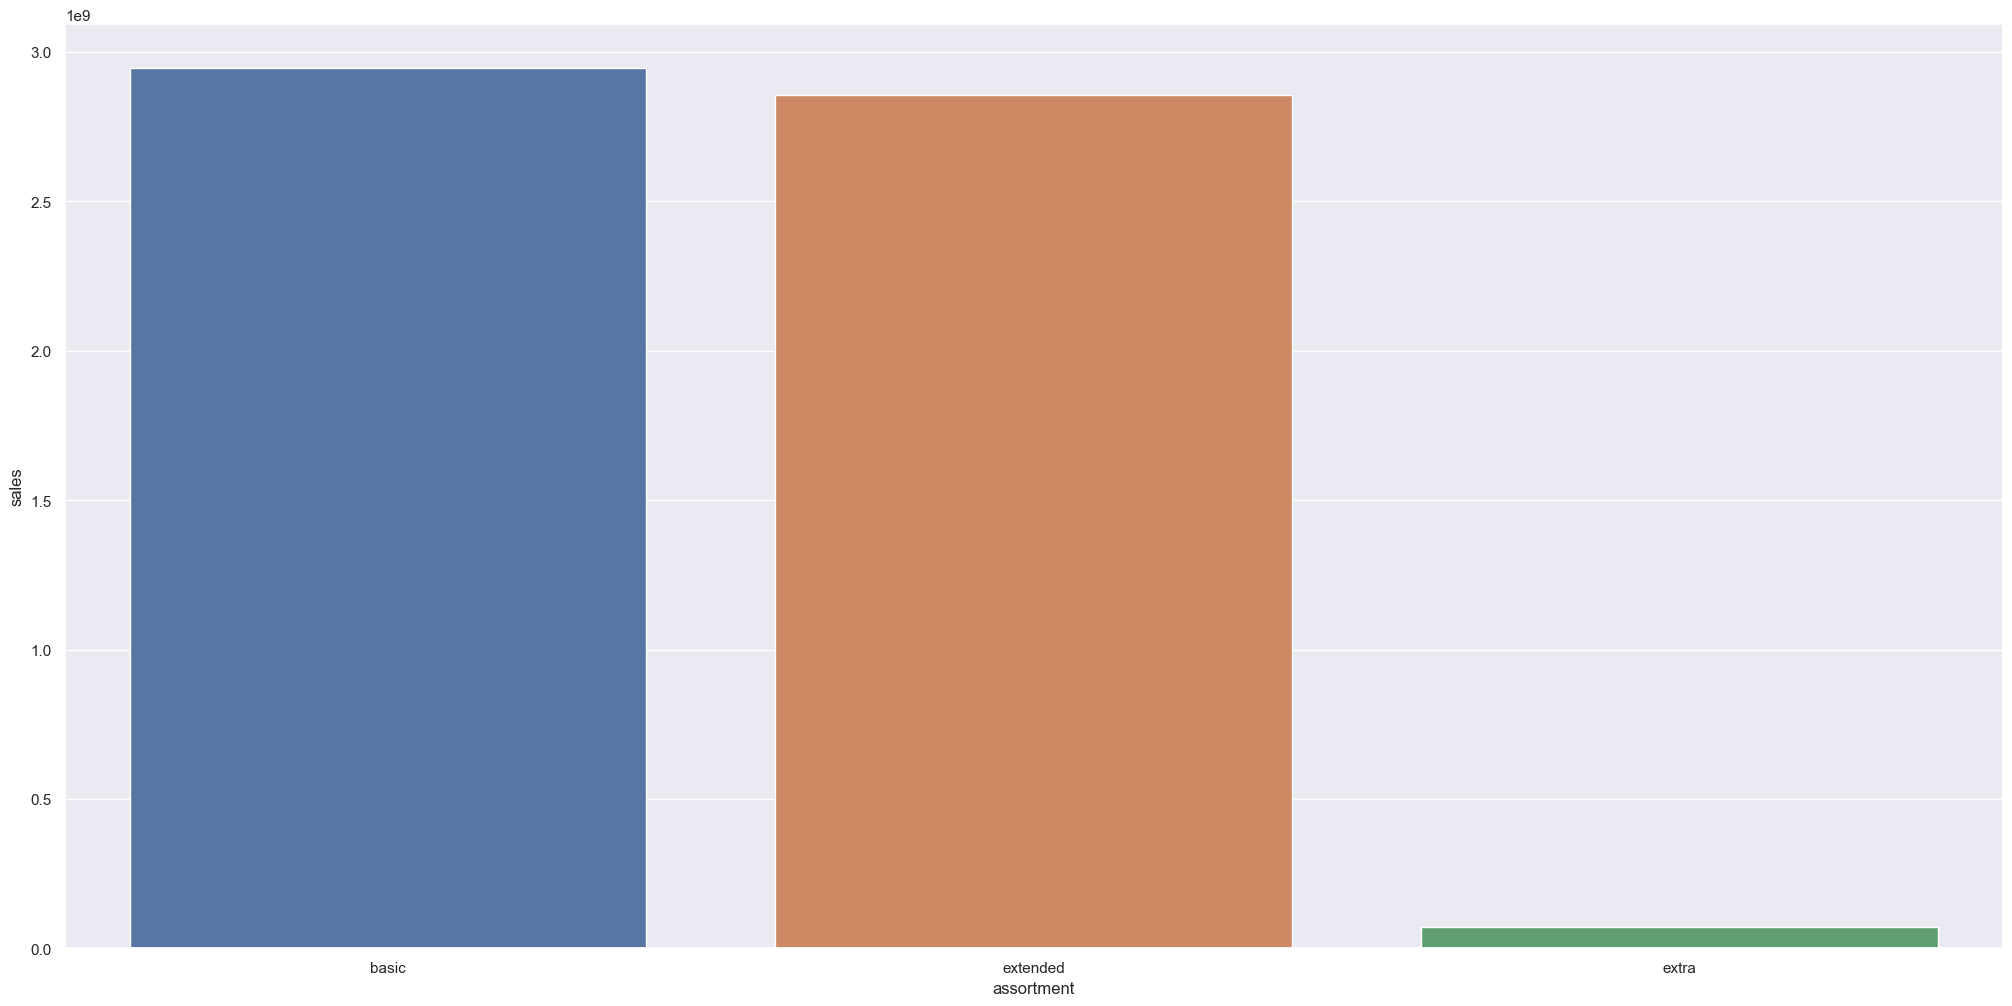

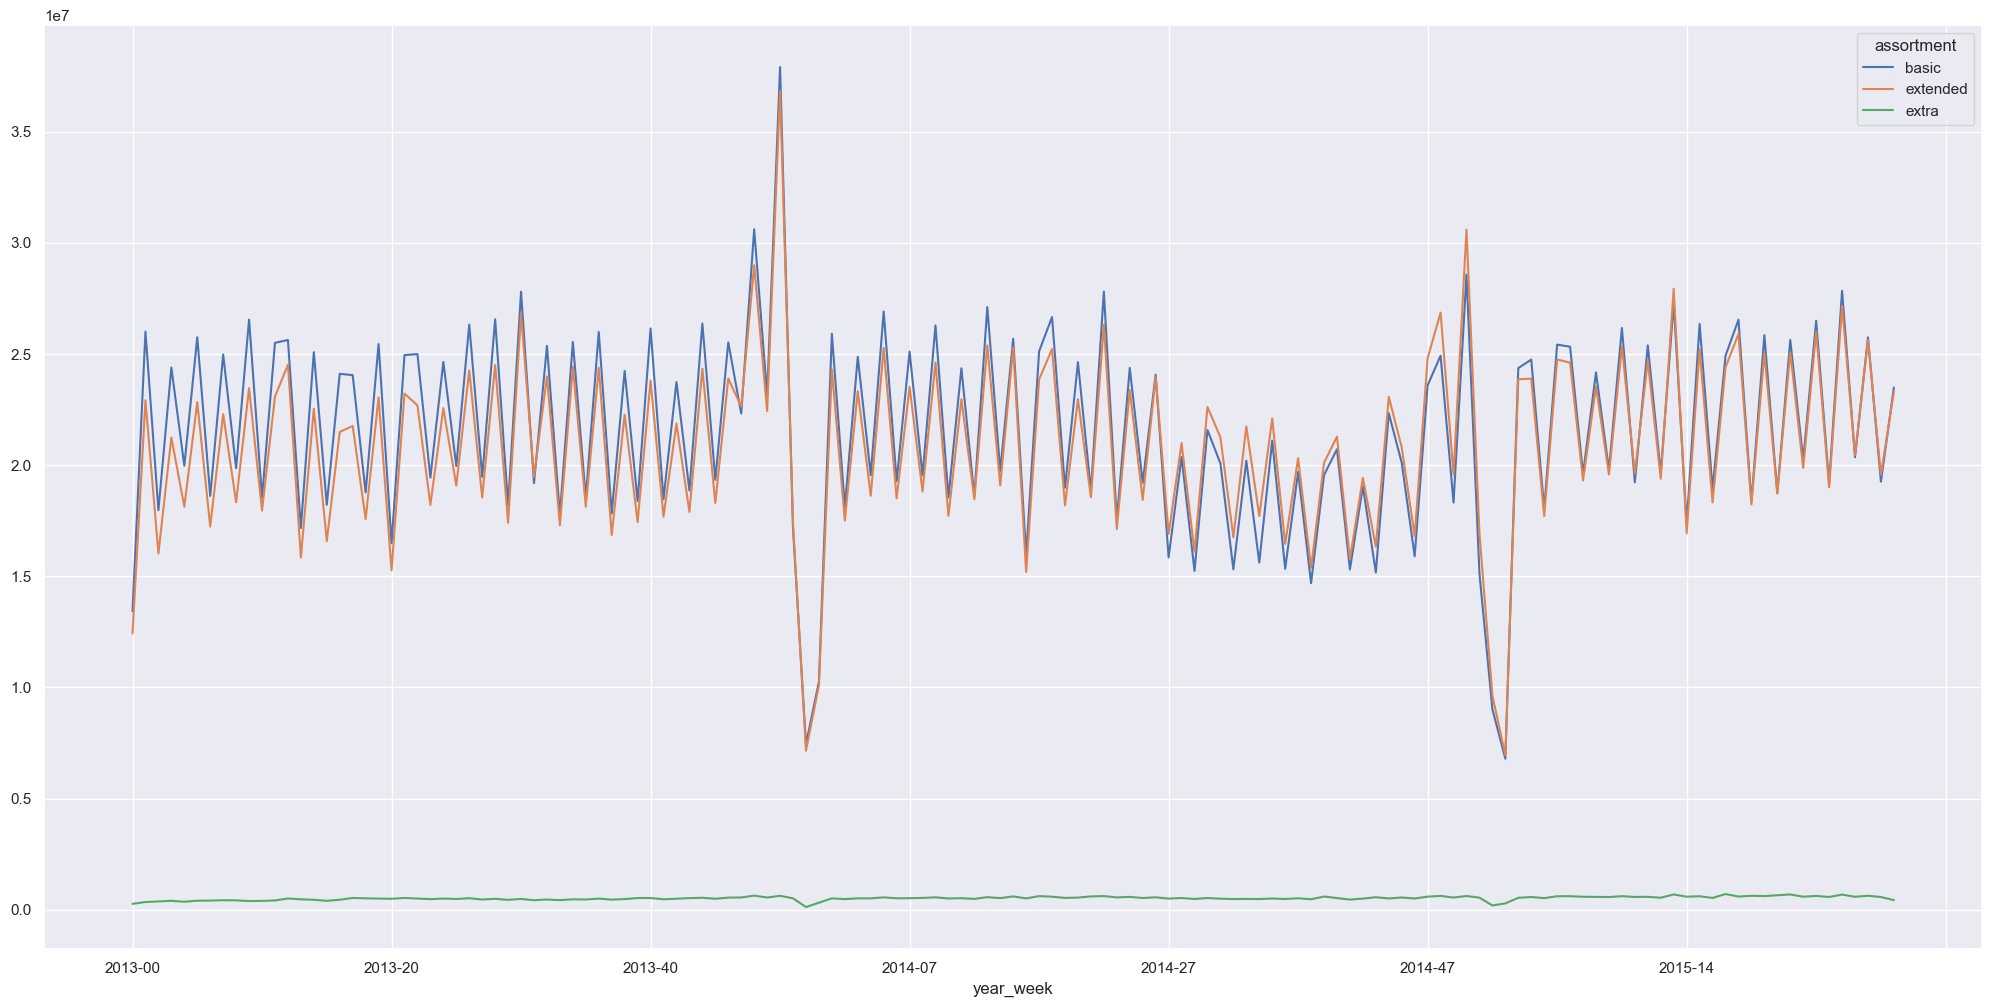

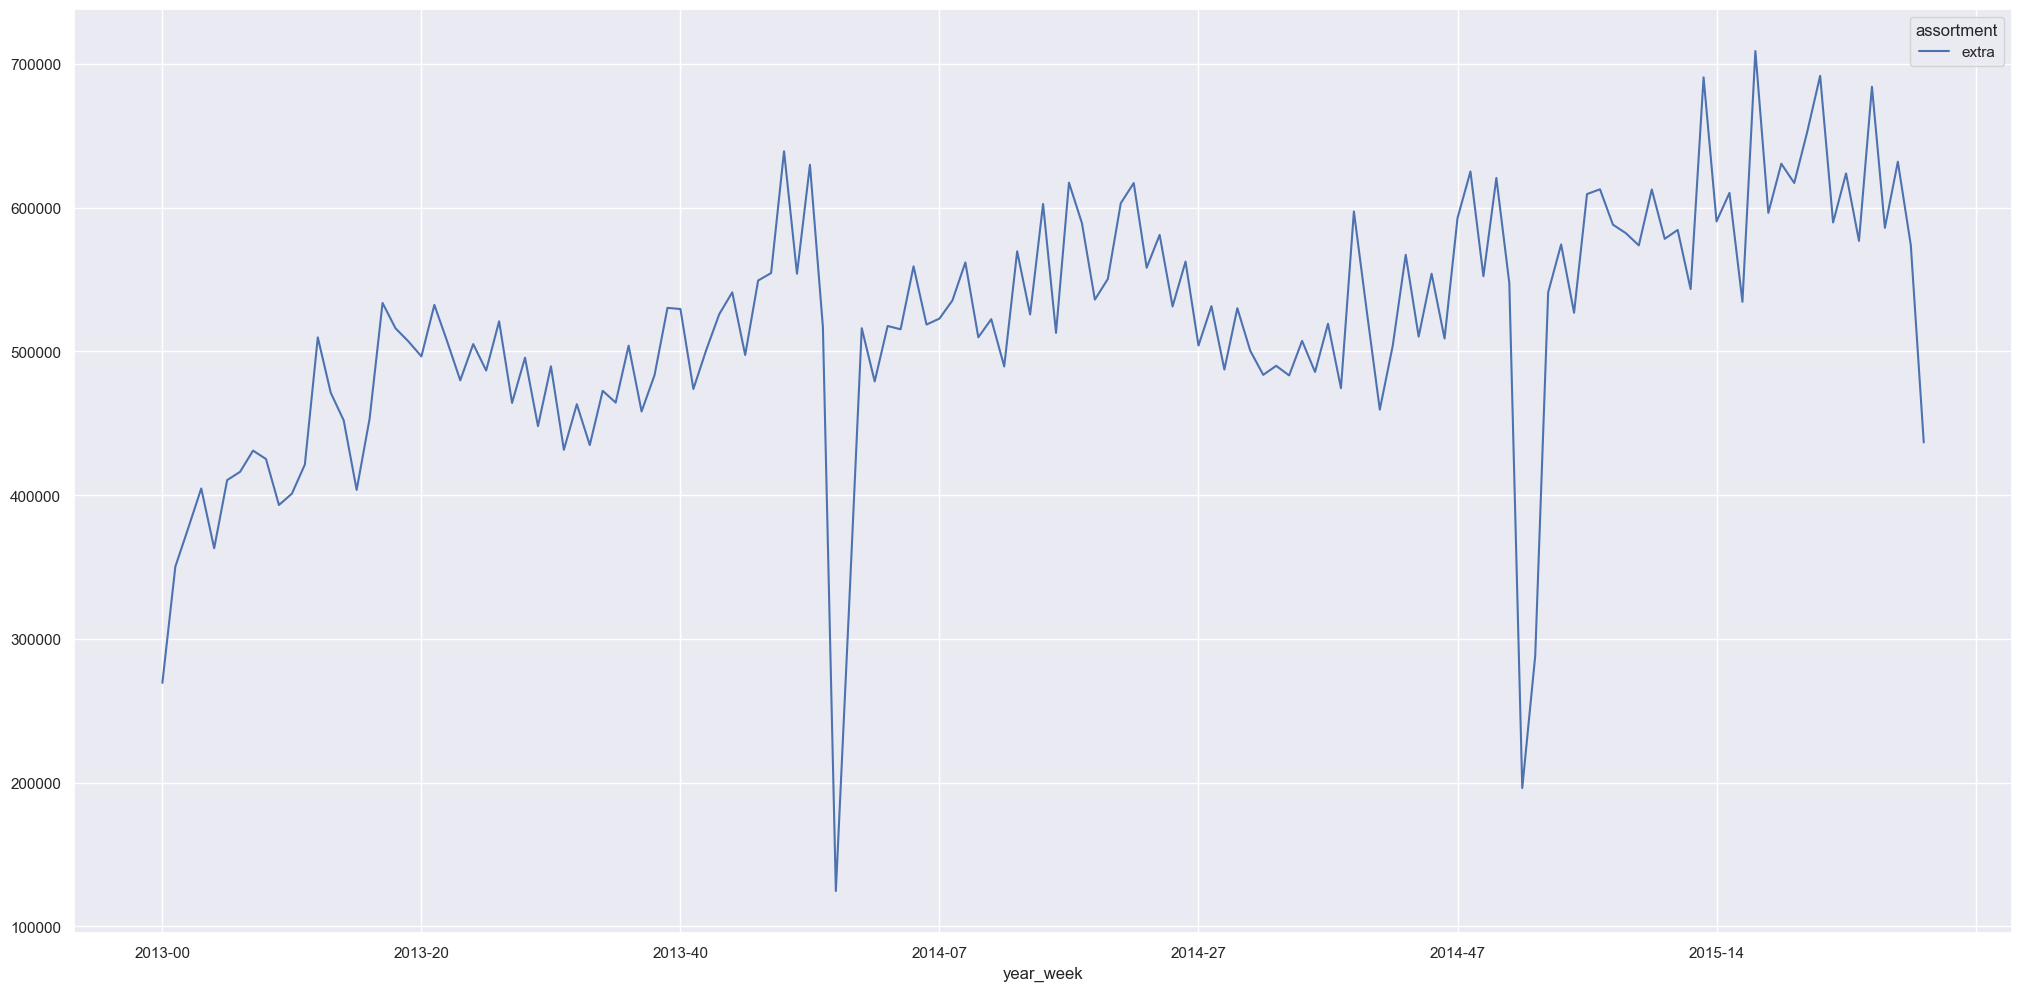

In [ ]:
aux1 = df4[['assortment','sales']].groupby('assortment').sum().reset_index()
sns.barplot(x='assortment', y='sales',hue='assortment', data=aux1)

aux2 = df4[['year_week','assortment','sales']].groupby(['year_week','assortment']).sum().reset_index()
aux2.pivot(index="year_week",columns="assortment",values="sales").plot()

aux3 = aux2[aux2['assortment'] == 'extra']
aux3.pivot(index="year_week",columns="assortment",values="sales").plot()

### H2. Lojas com competidores mais próximos deveriam vender menos.
**FALSA** Lojas com COMPETIDORES MAIS PRÓXIMOS vendem MAIS

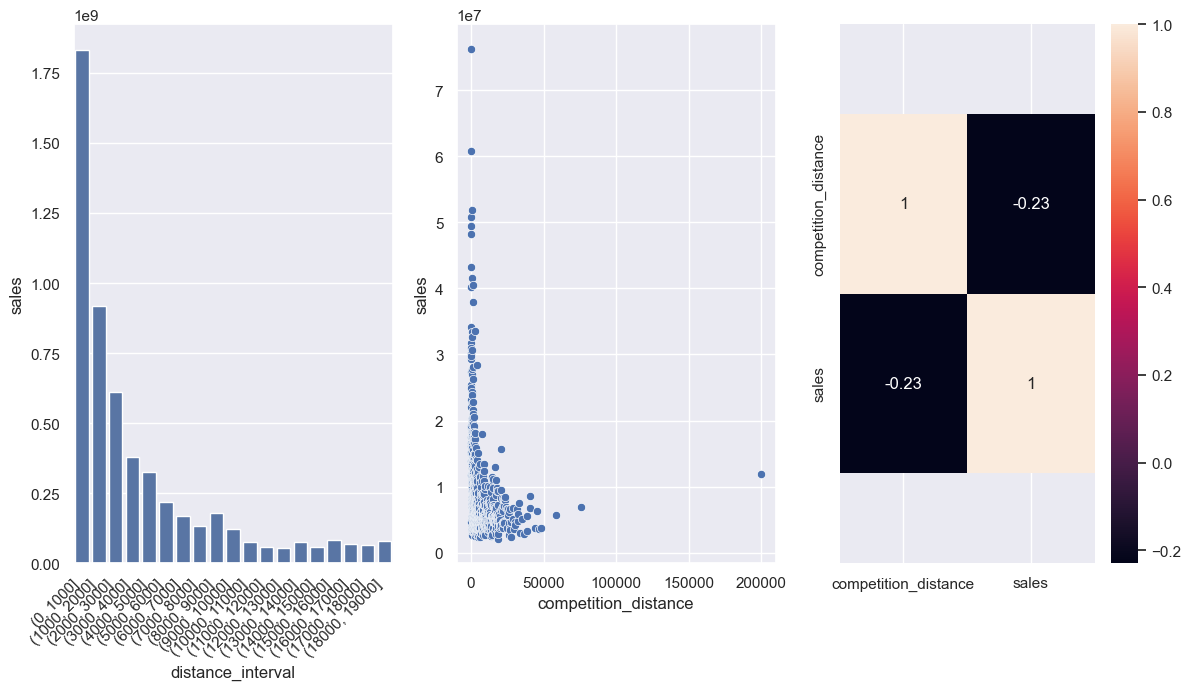

In [ ]:
plt.figure(figsize=(14, 7))

bins = np.arange(0, 20000 , 1000)

aux1 = df4[['competition_distance','sales']].groupby('competition_distance').sum().reset_index()
aux1['distance_interval'] = pd.cut(aux1['competition_distance'], bins)

aux2 = aux1.groupby('distance_interval', observed=True)['sales'].sum().reset_index()

plt.subplot(1,3,1)
sns.barplot(x='distance_interval', y='sales', data=aux2)
plt.xticks(rotation=45, ha='right');

plt.subplot(1,3,2)
sns.scatterplot(x='competition_distance', y='sales', data=aux1)

plt.subplot(1,3,3)
aux1 = df4[['competition_distance','sales']].groupby('competition_distance').sum().reset_index()
x = sns.heatmap(aux1.corr(method='pearson'),annot=True);
bottom,top = x.get_ylim()
x.set_ylim(bottom+0.5, top-0.5);

### H3. Lojas com competidores a mais tempo deveriam vender mais.

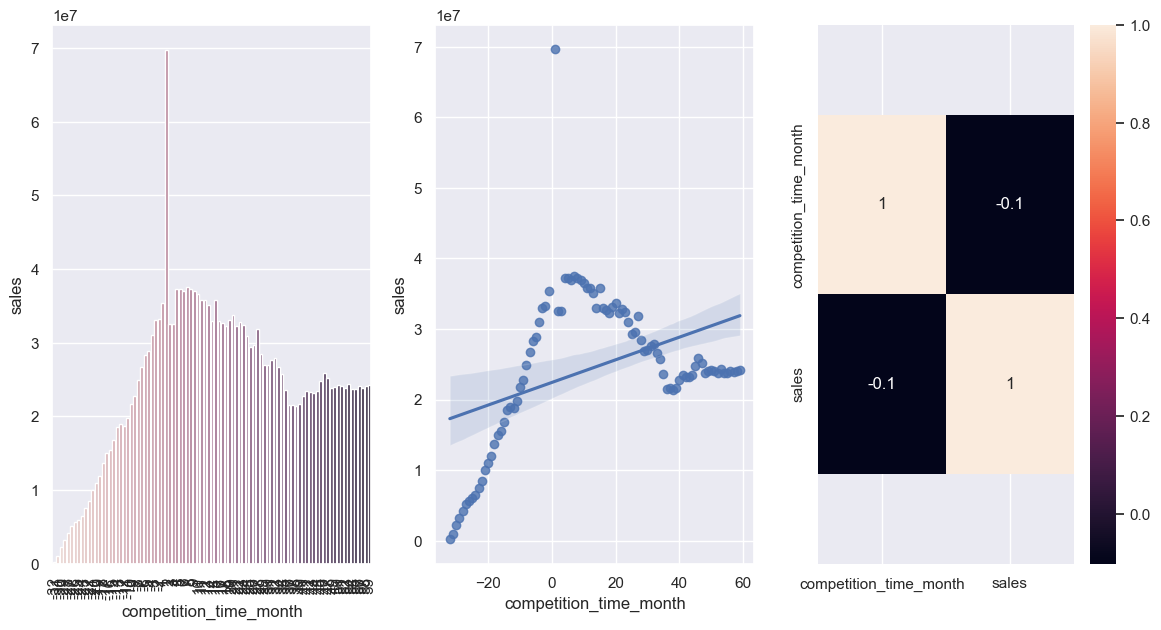

In [ ]:
plt.figure(figsize=(14, 7))

plt.subplot(1,3,1)
aux1 = df4[['competition_time_month','sales']].groupby('competition_time_month').sum().reset_index()
aux2 = aux1[(aux1['competition_time_month'] < 60) & (aux1['competition_time_month'] != 0)]
sns.barplot(x='competition_time_month',y='sales',hue='competition_time_month',data=aux2, legend=False)
plt.xticks(rotation=90);

plt.subplot(1,3,2)
sns.regplot(x='competition_time_month',y='sales', data=aux2)

plt.subplot(1,3,3)
x = sns.heatmap(aux1.corr(method='pearson'),annot=True);
bottom,top = x.get_ylim()
x.set_ylim(bottom+0.5, top-0.5);

### H4. Lojas com promoções ativas por mais tempo deveriam vender mais.

### H5. Lojas com mais dias de promoção deveriam vender mais

### H6. Lojas com mais promoções consecutivas deveriam vender mais.

### H7. Lojas abertas durante feriado de Natal deveriam vender mais.

### H8. Lojas deveriam vender mais ao longo dos anos.

### H9. Lojas deveriam vender mais no segundo semestre do ano.

### H10. Lojas deveriam vender mais depois do dia 10 de cada mês.

### H11. Lojas deveriam vender menos aos finais de semana.

### H12. Lojas deveriam vender menos durante os feriados escolares.

### 4.2.1 Resumo das Hipóteses

In [ ]:
tab =[['Hipoteses', 'Conclusao', 'Relevancia'],
['H1', 'Falsa', 'Baixa'],
['H2', 'Falsa', 'Media'],
['H3', 'Falsa', 'Media'],
['H4', 'Falsa', 'Baixa'],
['H5', '-', '-'],
['H6', 'Falsa', 'Baixa'],
['H7', 'Falsa', 'Media'],
['H8', 'Falsa', 'Alta'],
['H9', 'Falsa', 'Alta'],
['H10', 'Verdadeira', 'Alta'],
['H11', 'Verdadeira', 'Alta'],
['H12', 'Verdadeira', 'Baixa'],
]
print( tabulate( tab, headers='firstrow' ) )

Hipoteses    Conclusao    Relevancia
-----------  -----------  ------------
H1           Falsa        Baixa
H2           Falsa        Media
H3           Falsa        Media
H4           Falsa        Baixa
H5           -            -
H6           Falsa        Baixa
H7           Falsa        Media
H8           Falsa        Alta
H9           Falsa        Alta
H10          Verdadeira   Alta
H11          Verdadeira   Alta
H12          Verdadeira   Baixa


## 4.3 Análise Multivariada

## 4.3.1 Numerical Attributes

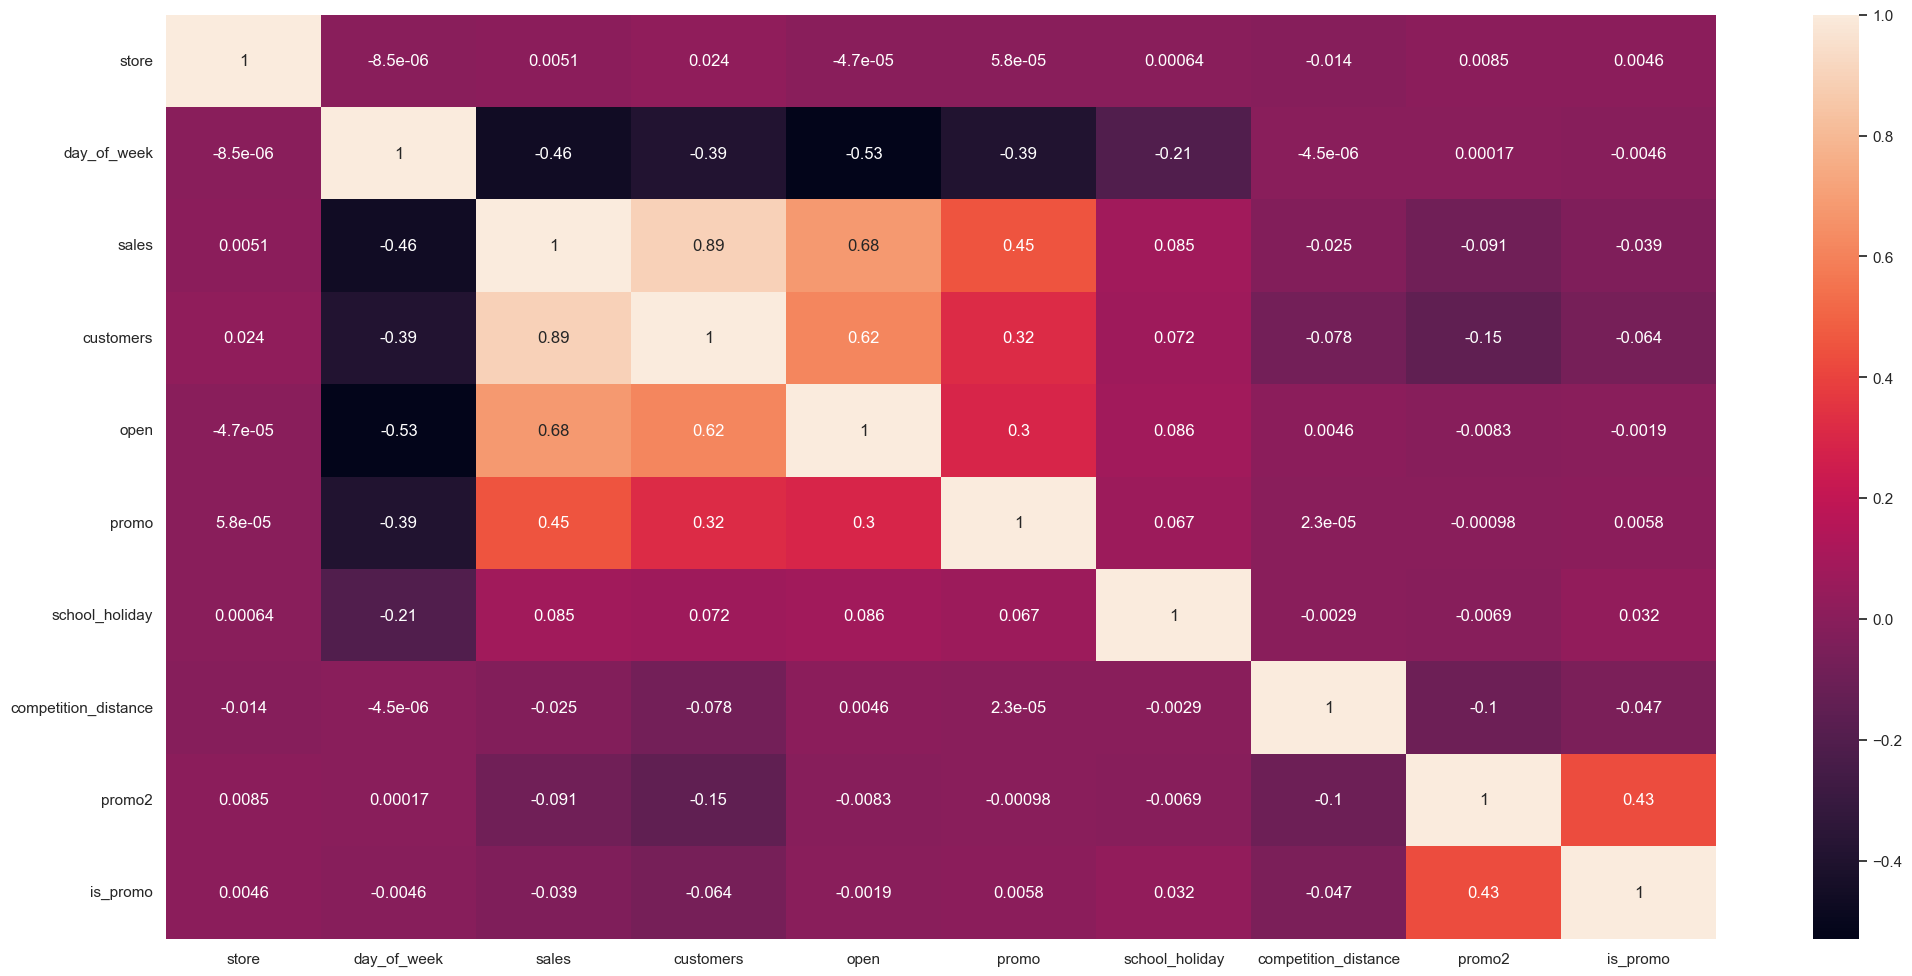

In [ ]:
#plt.figure(figsize=(18, 10))
correlacao = num_attributes.corr(method='pearson')
sns.heatmap(correlacao, annot=True);

## 4.3.2 Categorical Attributes

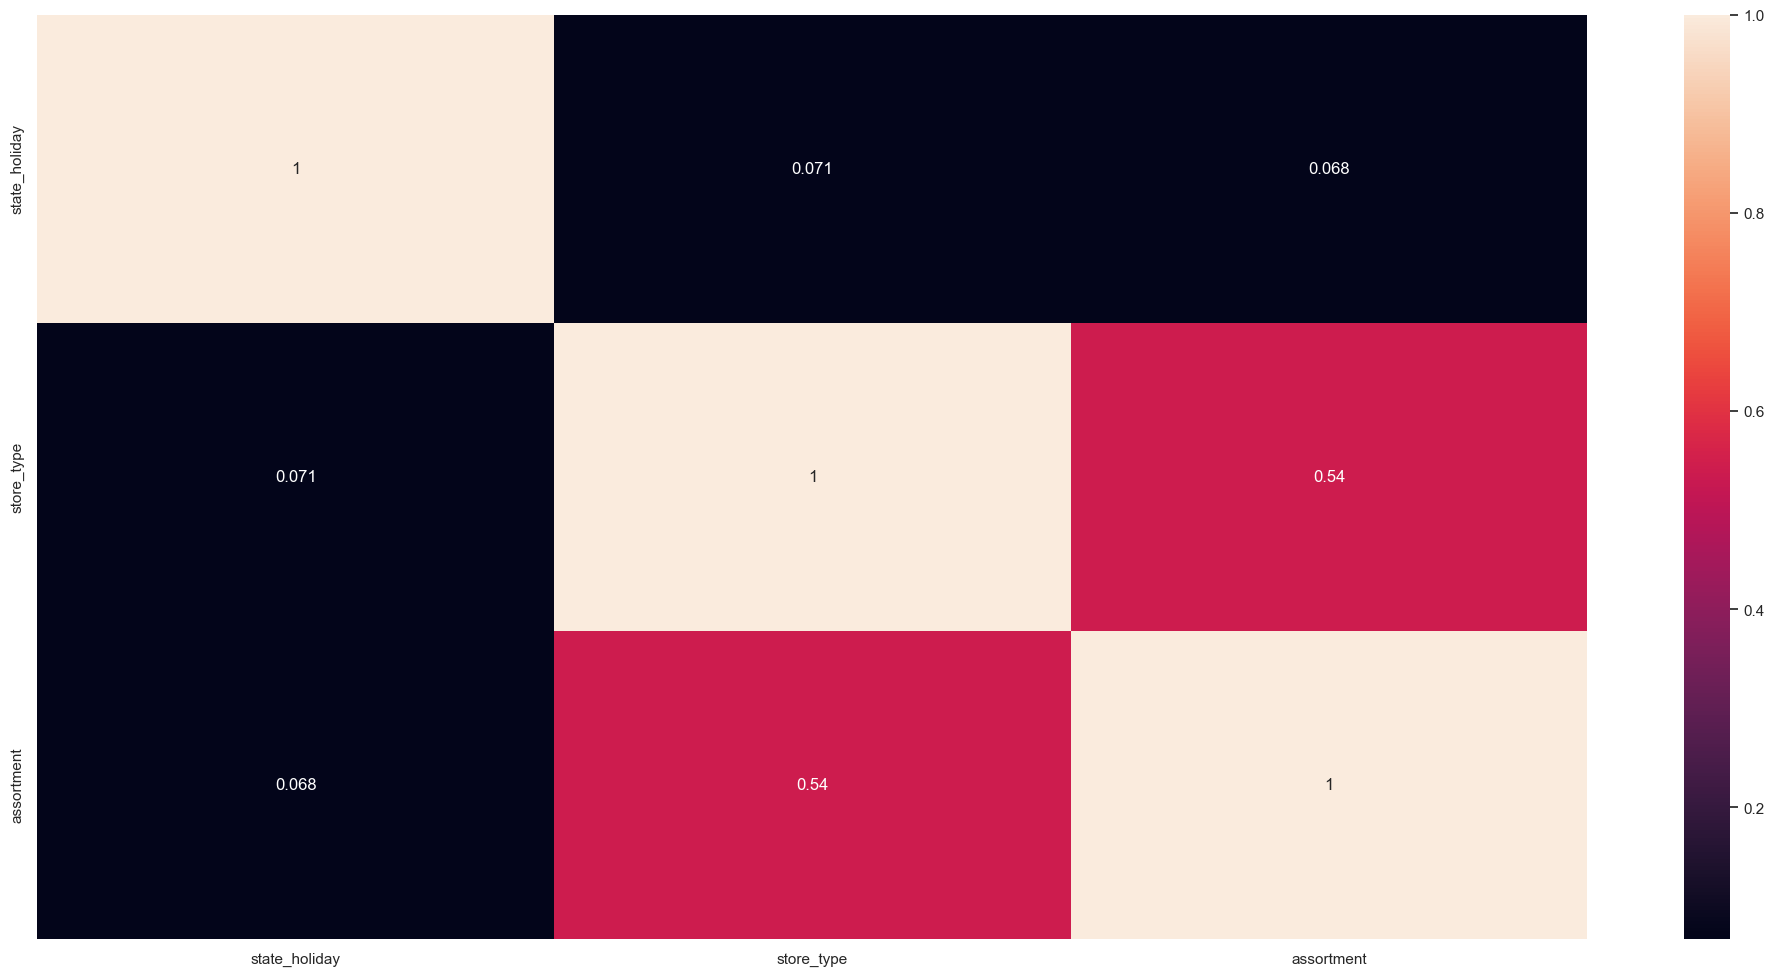

In [ ]:
a = df4.select_dtypes(include='object')

a1 = cramer_v( a['state_holiday'], a['state_holiday'] )
a2 = cramer_v( a['state_holiday'], a['store_type'] )
a3 = cramer_v( a['state_holiday'], a['assortment'] )

a4 = cramer_v( a['store_type'], a['state_holiday'] )
a5 = cramer_v( a['store_type'], a['store_type'] )
a6 = cramer_v( a['store_type'], a['assortment'] )

a7 = cramer_v( a['assortment'], a['state_holiday'] )
a8 = cramer_v( a['assortment'], a['store_type'] )
a9 = cramer_v( a['assortment'], a['assortment'] )

# Final dataset
d = pd.DataFrame( {'state_holiday': [a1, a2, a3],'store_type': [a4, a5, a6],'assortment': [a7, a8, a9] })
d = d.set_index( d.columns )
sns.heatmap( d, annot=True );

# 5.0 DATA PREPARATION

In [ ]:
df5 = df4.copy()

## 5.1 Normalização

## 5.2 Rescaling

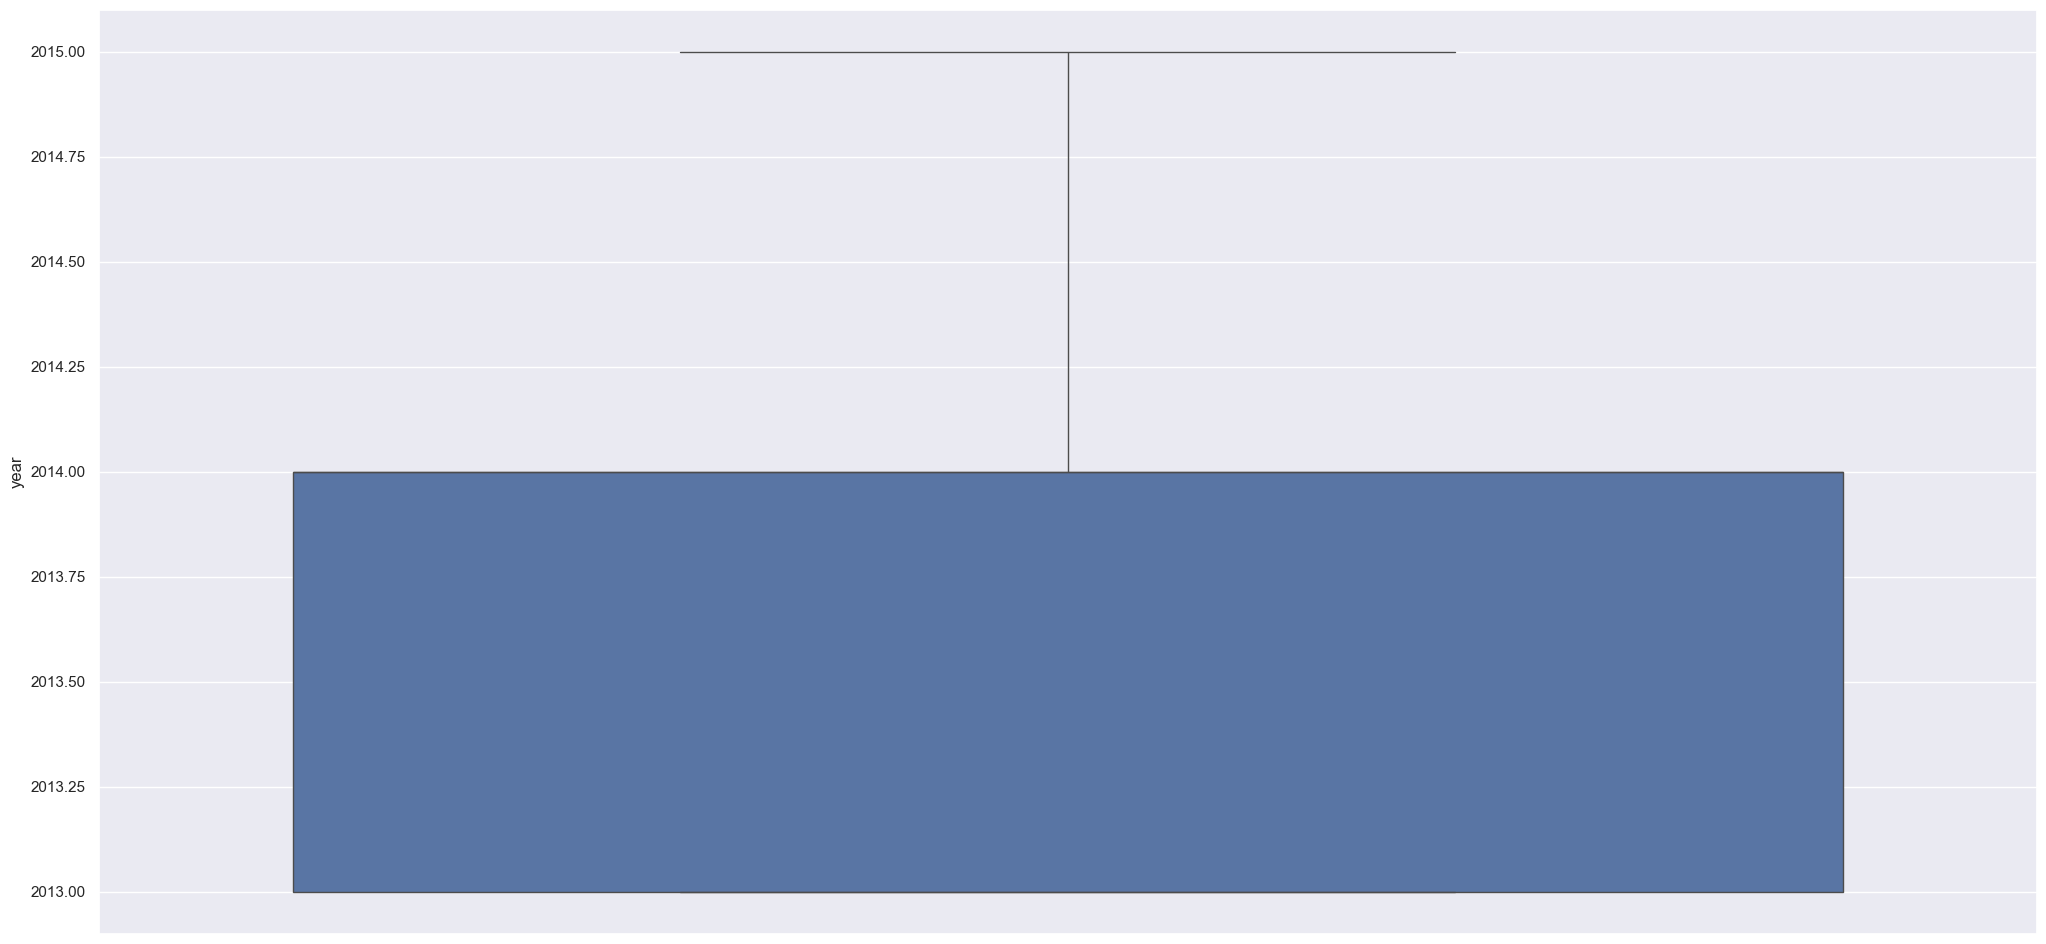

In [ ]:
a = df5.select_dtypes(include=['int64','float64'])
sns.boxplot(df5['year']); #verificar outliers. Se sim: rs. Se não mms

In [ ]:
rs = RobustScaler()
mms = MinMaxScaler()
#competition distance
df5['competition_distance'] = rs.fit_transform(df5[['competition_distance']].values)
pickle.dump(rs, open('parameter/competition_distance_scaler.pkl', 'wb'))

#competition time month
df5['competition_time_month'] = rs.fit_transform(df5[['competition_time_month']].values)
pickle.dump(rs, open('parameter/competition_time_month_scaler.pkl', 'wb'))
#promo time week
df5['promo_time_week'] = mms.fit_transform(df5[['promo_time_week']].values)
pickle.dump(mms, open('parameter/promo_time_week_scaler.pkl', 'wb'))

#year
df5['year'] = mms.fit_transform(df5[['year']].values)
pickle.dump(mms, open('parameter/year_scaler.pkl', 'wb'))


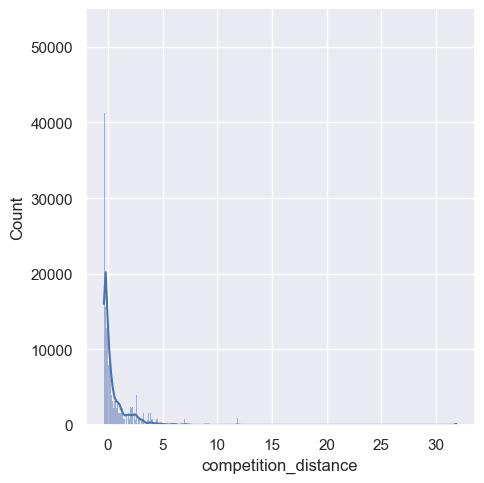

In [ ]:
sns.displot(df5['competition_distance'], kde=True);

In [ ]:
df5.head()

,store,day_of_week,date,sales,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week
0,1,5,2015-07-31,5263,1,regular_day,1,c,basic,-0.170968,9,2008,0,31,2015,0,1.0,7,31,31,2015-30,2008-09-01,0.918919,2015-07-27,0.287016
1,2,5,2015-07-31,6064,1,regular_day,1,a,basic,-0.283871,11,2007,1,13,2010,1,1.0,7,31,31,2015-30,2007-11-01,1.054054,2010-03-22,0.922551
2,3,5,2015-07-31,8314,1,regular_day,1,a,basic,1.903226,12,2006,1,14,2011,1,1.0,7,31,31,2015-30,2006-12-01,1.202703,2011-03-28,0.801822
3,4,5,2015-07-31,13995,1,regular_day,1,c,extended,-0.275806,9,2009,0,31,2015,0,1.0,7,31,31,2015-30,2009-09-01,0.743243,2015-07-27,0.287016
4,5,5,2015-07-31,4822,1,regular_day,1,a,basic,4.448387,4,2015,0,31,2015,0,1.0,7,31,31,2015-30,2015-04-01,-0.162162,2015-07-27,0.287016


## 5.3 Transformação

### 5.3.1 Encoding

In [ ]:
#state_holiday - one hot encoding
df5 = pd.get_dummies(df5, prefix=['state_holiday'], columns=['state_holiday'], dtype=int)

#store_type - label encoding
le = LabelEncoder()
df5['store_type'] = le.fit_transform(df5['store_type'])
pickle.dump(le, open('parameter/store_type_scaler.pkl', 'wb'))


#assortment
assortment_dict = {'basic': 1, 'extra': 2, 'extended': 3}
df5['assortment'] = df5['assortment'].map(assortment_dict)

In [ ]:
df5.head()

,store,day_of_week,date,sales,promo,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week,state_holiday_christmas,state_holiday_easter_holiday,state_holiday_public_holiday,state_holiday_regular_day
0,1,5,2015-07-31,5263,1,1,2,1,-0.170968,9,2008,0,31,2015,0,1.0,7,31,31,2015-30,2008-09-01,0.918919,2015-07-27,0.287016,0,0,0,1
1,2,5,2015-07-31,6064,1,1,0,1,-0.283871,11,2007,1,13,2010,1,1.0,7,31,31,2015-30,2007-11-01,1.054054,2010-03-22,0.922551,0,0,0,1
2,3,5,2015-07-31,8314,1,1,0,1,1.903226,12,2006,1,14,2011,1,1.0,7,31,31,2015-30,2006-12-01,1.202703,2011-03-28,0.801822,0,0,0,1
3,4,5,2015-07-31,13995,1,1,2,3,-0.275806,9,2009,0,31,2015,0,1.0,7,31,31,2015-30,2009-09-01,0.743243,2015-07-27,0.287016,0,0,0,1
4,5,5,2015-07-31,4822,1,1,0,1,4.448387,4,2015,0,31,2015,0,1.0,7,31,31,2015-30,2015-04-01,-0.162162,2015-07-27,0.287016,0,0,0,1


### 5.3.2 Response Variable Transformation

In [ ]:
df5['sales'] = np.log1p(df5['sales'])

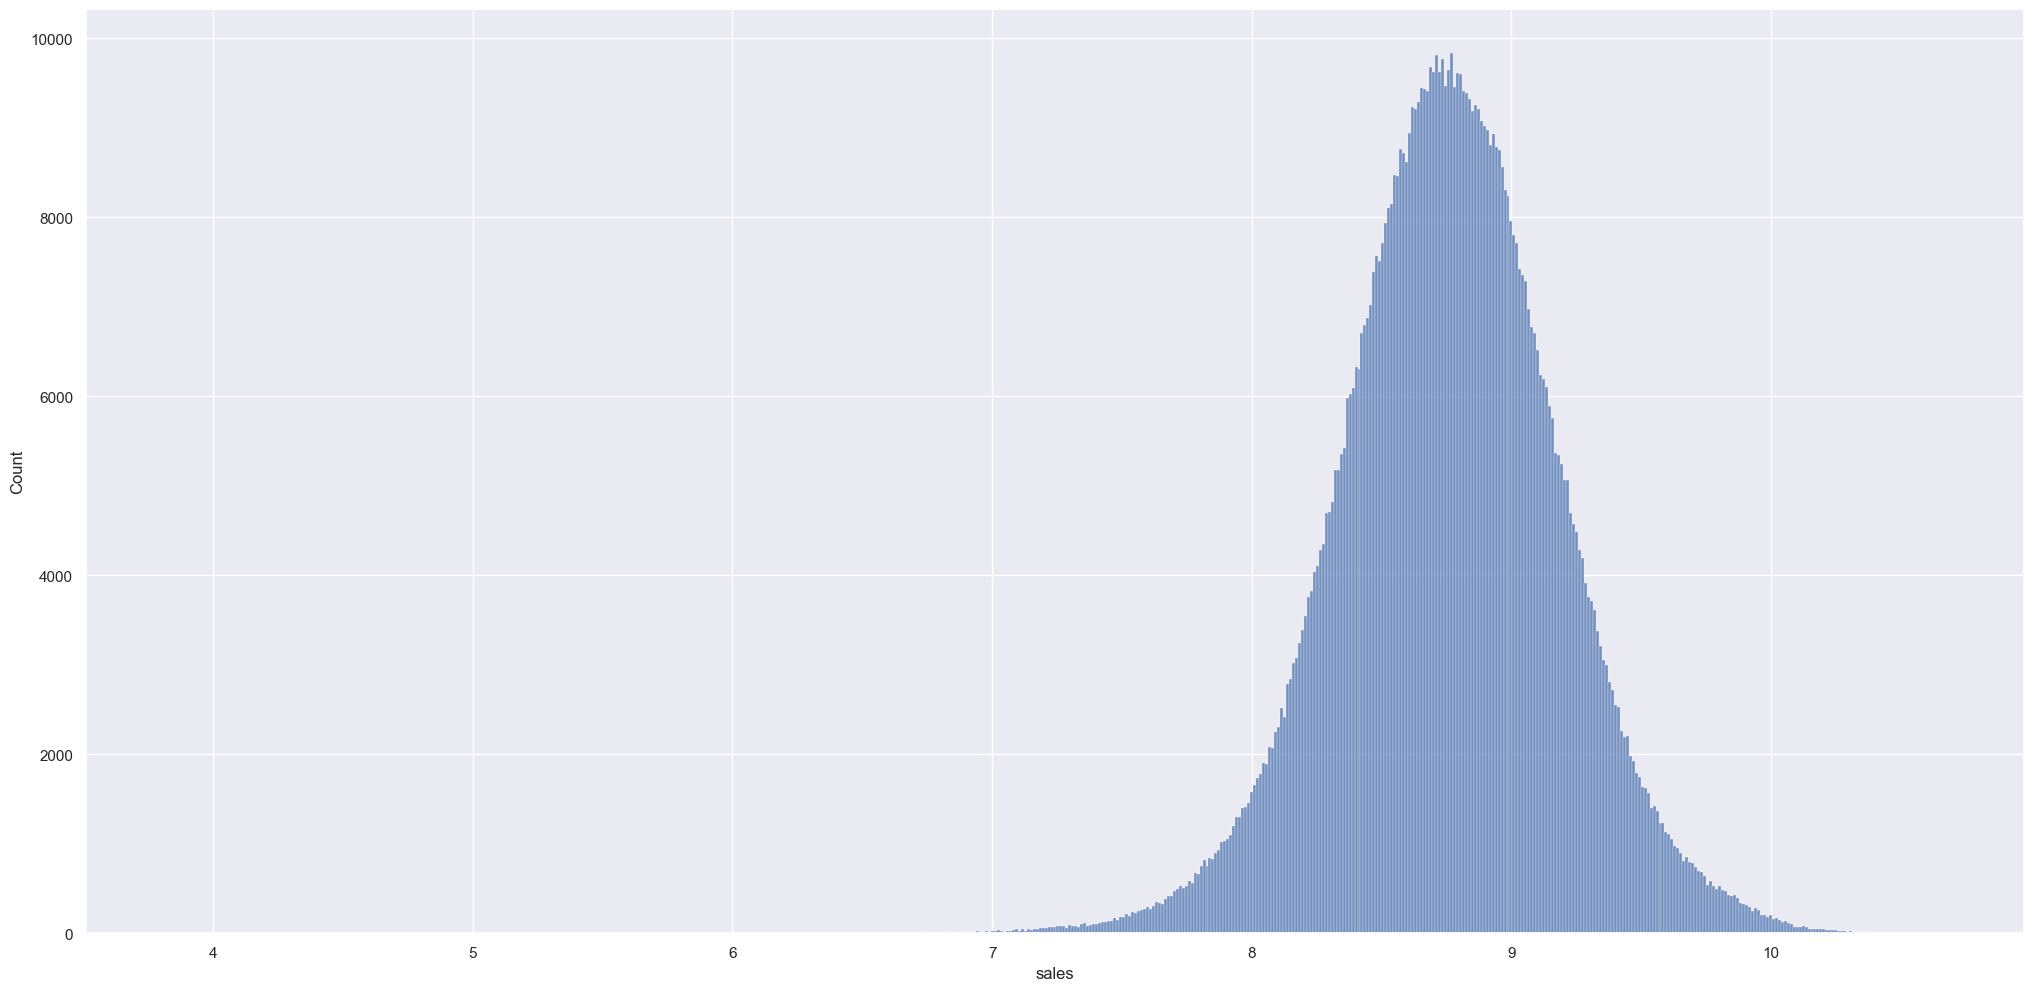

In [ ]:
sns.histplot(df5['sales']);

### 5.3.2 Nature Transformation

In [ ]:
# day of week
df5['day_of_week_sin'] = df5['day_of_week'].apply( lambda x: np.sin( x * ( 2 *np.pi/7 ) ) )
df5['day_of_week_cos'] = df5['day_of_week'].apply( lambda x: np.cos( x * ( 2 *np.pi/7 ) ) )

# month
df5['month_sin'] = df5['month'].apply( lambda x: np.sin( x * ( 2 * np.pi/12 )) )
df5['month_cos'] = df5['month'].apply( lambda x: np.cos( x * ( 2 * np.pi/12 )) )

# day
df5['day_sin'] = df5['day'].apply( lambda x: np.sin( x * ( 2 * np.pi/30 ) ) )
df5['day_cos'] = df5['day'].apply( lambda x: np.cos( x * ( 2 * np.pi/30 ) ) )

# week of year
df5['week_of_year_sin'] = df5['week_of_year'].apply( lambda x: np.sin( x * ( 2 * np.pi/52 ) ) )
df5['week_of_year_cos'] = df5['week_of_year'].apply( lambda x: np.cos( x * ( 2 * np.pi/52 ) ) )



In [ ]:
df5.head()

,store,day_of_week,date,sales,promo,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week,state_holiday_christmas,state_holiday_easter_holiday,state_holiday_public_holiday,state_holiday_regular_day,day_of_week_sin,day_of_week_cos,month_sin,month_cos,day_sin,day_cos,week_of_year_sin,week_of_year_cos
0,1,5,2015-07-31,8.568646,1,1,2,1,-0.170968,9,2008,0,31,2015,0,1.0,7,31,31,2015-30,2008-09-01,0.918919,2015-07-27,0.287016,0,0,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
1,2,5,2015-07-31,8.710290,1,1,0,1,-0.283871,11,2007,1,13,2010,1,1.0,7,31,31,2015-30,2007-11-01,1.054054,2010-03-22,0.922551,0,0,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
2,3,5,2015-07-31,9.025816,1,1,0,1,1.903226,12,2006,1,14,2011,1,1.0,7,31,31,2015-30,2006-12-01,1.202703,2011-03-28,0.801822,0,0,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
3,4,5,2015-07-31,9.546527,1,1,2,3,-0.275806,9,2009,0,31,2015,0,1.0,7,31,31,2015-30,2009-09-01,0.743243,2015-07-27,0.287016,0,0,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
4,5,5,2015-07-31,8.481151,1,1,0,1,4.448387,4,2015,0,31,2015,0,1.0,7,31,31,2015-30,2015-04-01,-0.162162,2015-07-27,0.287016,0,0,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984


# 6.0 FEATURE SELECTION

In [ ]:
df6 = df5.copy()

## 6.1 Split Dataframe Into Training and Teste Dataset

In [ ]:
df6.head()

,store,day_of_week,date,sales,promo,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week,state_holiday_christmas,state_holiday_easter_holiday,state_holiday_public_holiday,state_holiday_regular_day,day_of_week_sin,day_of_week_cos,month_sin,month_cos,day_sin,day_cos,week_of_year_sin,week_of_year_cos
0,1,5,2015-07-31,8.568646,1,1,2,1,-0.170968,9,2008,0,31,2015,0,1.0,7,31,31,2015-30,2008-09-01,0.918919,2015-07-27,0.287016,0,0,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
1,2,5,2015-07-31,8.710290,1,1,0,1,-0.283871,11,2007,1,13,2010,1,1.0,7,31,31,2015-30,2007-11-01,1.054054,2010-03-22,0.922551,0,0,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
2,3,5,2015-07-31,9.025816,1,1,0,1,1.903226,12,2006,1,14,2011,1,1.0,7,31,31,2015-30,2006-12-01,1.202703,2011-03-28,0.801822,0,0,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
3,4,5,2015-07-31,9.546527,1,1,2,3,-0.275806,9,2009,0,31,2015,0,1.0,7,31,31,2015-30,2009-09-01,0.743243,2015-07-27,0.287016,0,0,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
4,5,5,2015-07-31,8.481151,1,1,0,1,4.448387,4,2015,0,31,2015,0,1.0,7,31,31,2015-30,2015-04-01,-0.162162,2015-07-27,0.287016,0,0,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984


In [ ]:
cols_drop = ['week_of_year','day','month','day_of_week','promo_since','competition_since','year_week']
df6 = df6.drop(cols_drop, axis=1)

In [ ]:
df6[['store','date']].groupby('store').max().reset_index()['date'][0] - datetime.timedelta(weeks=6)

Timestamp('2015-06-19 00:00:00')

In [ ]:
# training dataset
X_train = df6.loc[df6['date'] < '2015-06-19',:]
y_train = X_train['sales']

#test dataset
X_test = df6.loc[df6['date'] >= '2015-06-19',:]
y_test = X_test['sales']

print ('training min date: {}'.format(X_train['date'].min()))
print ('training max date: {}'.format(X_train['date'].max()))

print ('\ntest min date: {}'.format(X_test['date'].min()))
print ('test max date: {}'.format(X_test['date'].max()))

training min date: 2013-01-01 00:00:00
training max date: 2015-06-18 00:00:00

test min date: 2015-06-19 00:00:00
test max date: 2015-07-31 00:00:00


## 6.2 Boruta as Feature Selector

In [ ]:
#training and test dataset for Boruta
X_train_n = X_train.drop(['date','sales'], axis=1).values
y_train_n = y_train.values.ravel()

#define ExtraTreesRegressor
etr = ExtraTreesRegressor(n_jobs=-1)

#define Boruta
#boruta = BorutaPy(etr, n_estimators='auto', verbose=2, random_state=42).fit(X_train_n, y_train_n)

In [ ]:
#cols_selected = boruta.support_.tolist()

#best features
#X_train_fs = X_train.drop(['date','sales'],axis=1)
#cols_selected_boruta = X_train_fs.iloc[:,cols_selected].columns.to_list()

#cols_not_selected_boruta = list(np.setdiff1d(X_train_fs.columns, cols_selected_boruta))

## 6.3 Manual Feature Selection

In [ ]:
cols_not_selected_boruta = [
    'is_promo',
    'state_holiday_christmas',
    'state_holiday_easter_holiday',
    'state_holiday_public_holiday',
    'state_holiday_regular_day']

cols_selected_boruta = [ 
    'store',
    'promo',
    'school_holiday',
    'store_type',
    'assortment',
    'competition_distance',
    'competition_open_since_month',
    'competition_open_since_year',
    'promo2',
    'promo2_since_week',
    'promo2_since_year',
    'year',
    'competition_time_month',
    'promo_time_week',
    'day_of_week_sin',
    'day_of_week_cos',
    'month_sin',
    'month_cos',
    'day_sin',
    'day_cos',
    'week_of_year_sin',
    'week_of_year_cos']

#columns to add
feat_to_add = ['date', 'sales']



In [ ]:
cols_selected_boruta


['store',
 'promo',
 'school_holiday',
 'store_type',
 'assortment',
 'competition_distance',
 'competition_open_since_month',
 'competition_open_since_year',
 'promo2',
 'promo2_since_week',
 'promo2_since_year',
 'year',
 'competition_time_month',
 'promo_time_week',
 'day_of_week_sin',
 'day_of_week_cos',
 'month_sin',
 'month_cos',
 'day_sin',
 'day_cos',
 'week_of_year_sin',
 'week_of_year_cos']

# 7.0 MACHINE LEARNING MODELLING

In [ ]:
#sem variável resposta
x_train = X_train[cols_selected_boruta]
x_test = X_test[cols_selected_boruta]

#com variável resposta
cols_selected_boruta_full = cols_selected_boruta.copy()
cols_selected_boruta_full.extend(feat_to_add)

x_training = X_train[cols_selected_boruta_full]

In [ ]:
x_test.head()

,store,promo,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,year,competition_time_month,promo_time_week,day_of_week_sin,day_of_week_cos,month_sin,month_cos,day_sin,day_cos,week_of_year_sin,week_of_year_cos
0,1,1,1,2,1,-0.170968,9,2008,0,31,2015,1.0,0.918919,0.287016,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
1,2,1,1,0,1,-0.283871,11,2007,1,13,2010,1.0,1.054054,0.922551,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
2,3,1,1,0,1,1.903226,12,2006,1,14,2011,1.0,1.202703,0.801822,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
3,4,1,1,2,3,-0.275806,9,2009,0,31,2015,1.0,0.743243,0.287016,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
4,5,1,1,0,1,4.448387,4,2015,0,31,2015,1.0,-0.162162,0.287016,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984


## 7.1 Average Model

In [ ]:
aux1 = x_test.copy()
aux1['sales'] = y_test.copy()

#prediction
aux2 = aux1[['store','sales']].groupby('store').mean().reset_index().rename(columns={'sales': 'predictions'})
aux1 = pd.merge(aux1,aux2,how='left',on='store')

yhat_baseline = aux1['predictions']

#performance
baseline_result = ml_error('Average Model', np.expm1(y_test), np.expm1(yhat_baseline))
baseline_result 



,Model Name,MAE,MAPE,RMSE
0,Average Model,1354.800353,0.455051,1835.135542


## 7.2 Linear Regression Model

In [ ]:
#model
lr = LinearRegression().fit(x_train, y_train)

#prediction
yhat_lr = lr.predict(x_test)

#performance
lr_result = ml_error('Linear Regression', np.expm1(y_test), np.expm1(yhat_lr))
lr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression,1863.859278,0.286238,2689.362778


### 7.2.1 Linear Regression Model - Cross Validation

In [ ]:
lr_result_cv = cross_validation(x_training,5,"Linear Regression",lr)
lr_result_cv

,Model Name,MAE CV,MAPE CV,RSME CV
0,Linear Regression,1976.45 +/- 42.03,0.29 +/- 0.0,2838.08 +/- 72.24


## 7.3 Linear Regression Regularized Model - Lasso

In [ ]:
#model
lrr = Lasso(alpha=0.01).fit(x_train, y_train)

#prediction
yhat_lrr = lrr.predict(x_test)

#performance
lrr_result = ml_error('Linear Regression - Lasso', np.expm1(y_test), np.expm1(yhat_lrr))
lrr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression - Lasso,1891.704881,0.289106,2744.451737


### 7.3.1 Lasso - Cross Validation

In [ ]:
lrr_result_cv = cross_validation(x_training,5,"Lasso",lrr)
lrr_result_cv

,Model Name,MAE CV,MAPE CV,RSME CV
0,Lasso,2035.84 +/- 54.02,0.29 +/- 0.0,2964.68 +/- 89.66


## 7.4 Random Forest Regressor

In [ ]:
#model
#rf = RandomForestRegressor(n_estimators=100,n_jobs=-1,random_state=42).fit(x_train, y_train)

#prediction
#yhat_rf = rf.predict(x_test)

#performance
#rf_result = ml_error('RandomForestRegressor', np.expm1(y_test), np.expm1(yhat_rf))


In [ ]:
#rf_result = pd.DataFrame({'Model Name': 'RandomForestRegressor',
#                                   'MAE': 679.62,
#                                   'MAPE': 0.0999,
#                                  'RMSE': 1011.19}, index=[0])
#rf_result

### 7.4.1 Random Forest Regressor - Cross Validation

In [ ]:
#rf_result_cv = cross_validation(x_training,5,"Random Forest Regressor",rf,verbose=True)
#rf_result_cv

## 7.5 XGBoost Regressor

In [ ]:
#model_xgb = xgb.XGBRegressor(objective='reg:squarederror',
                             n_estimators=100,
                             eta=0.01,
                             max_depth=15,
                             subsample=0.3,
                             colsample_bytree=0.9).fit(x_train, y_train)

#prediction
#yhat_xgb = model_xgb.predict(x_test)

#performance
#xgb_result = ml_error('XGBoost Regressor', np.expm1(y_test), np.expm1(yhat_xgb))
#xgb_result

,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,1410.88403,0.204191,2098.252056


### 7.5.1 XGBoost Regressor - Cross Validation

In [ ]:
#xgb_result_cv = cross_validation(x_training,5,"XGBoost Regressor",model_xgb,verbose=True)
#xgb_result_cv


KFold Number:5

KFold Number:4

KFold Number:3

KFold Number:2

KFold Number:1


,Model Name,MAE CV,MAPE CV,RSME CV
0,XGBoost Regressor,1540.36 +/- 52.08,0.2 +/- 0.01,2289.8 +/- 90.95


## 7.6 Compare Model's Performance

### 7.6.1 Single Performance

In [ ]:
#modelling_result = pd.concat([baseline_result,lr_result,lrr_result,rf_result,xgb_result])
#modelling_result.sort_values('RMSE')

### 7.6.2 Real Performance - Cross Validation

In [ ]:
#modelling_result_cv = pd.concat([lr_result_cv,lrr_result_cv,rf_result_cv,xgb_result_cv])
#modelling_result_cv

# 8.0 HYPERPARAMETER FINE TUNING

## 8.1 Random Search

In [ ]:
param = {
    'n_estimators': [1500, 1700, 2500, 3000, 3500],
    'eta': [0.01, 0.03],
    'max_depth': [3, 11, 13],
    'subsample': [0.1, 0.5, 0.7],
    'colsample_bytree': [0.3, 0.7, 0.9],
    'min_child_weight': [3, 8, 15]
    }

MAX_EVAL = 5

In [ ]:
#final_result = pd.DataFrame()

#for i in range(MAX_EVAL):
    # choose values for parameters randomly
    #hp = { k: random.sample (v,1)[0] for k,v in param.items()}
   # print (hp)

    #model
   # model_xgb = xgb.XGBRegressor(objective='reg:squarederror',
         #                    n_estimators=hp['n_estimators'],
              #               eta=hp['eta'],
              #               max_depth=hp['max_depth'],
               #              subsample=hp['subsample'],
                #             colsample_bytree=hp['colsample_bytree'],
                #             min_child_weight=hp['min_child_weight'])



    #performance
  #  result = cross_validation(x_training, 2 ,'XGBoost Regressor', model_xgb)
  #  final_result = pd.concat([final_result,result])
    
#final_result

## 8.2 Final Model

In [ ]:
param_tuned = {
    'n_estimators':3000,
    'eta':0.03,
    'max_depth':5,
    'subsample': 0.7,
    'colsample_bytree': 0.7,
    'min_child_weight': 3 
    }



In [ ]:
#model
model_xgb_tuned = xgb.XGBRegressor(objective='reg:squarederror',
                             n_estimators=param_tuned['n_estimators'],
                             eta=param_tuned['eta'],
                             max_depth=param_tuned['max_depth'],
                             subsample=param_tuned['subsample'],
                             colsample_bytree=param_tuned['colsample_bytree'],
                             min_child_weight=param_tuned['min_child_weight']).fit(x_train, y_train)

# prediction
yhat_xgb_tuned = model_xgb_tuned.predict(x_test)

#performance
xgb_result_tuned = ml_error('XGBoost Regressor',np.expm1(y_test),np.expm1(yhat_xgb_tuned))
xgb_result_tuned

,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,770.958663,0.114647,1128.255705


In [ ]:
np.expm1(y_test).min() 

569.0000000000002

In [ ]:
np.expm1(yhat_xgb_tuned)[124]

12660.25

# 9.0 TRADUÇÃO E INTERPRETAÇÃO DO ERRO

In [ ]:
df9 = X_test[cols_selected_boruta_full]

#rescale
df9['sales'] = np.expm1(df9['sales'])
df9['predictions'] = np.expm1(yhat_xgb_tuned)

C:\Users\rseme\AppData\Local\Temp\ipykernel_21668\403577207.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df9['sales'] = np.expm1(df9['sales'])
C:\Users\rseme\AppData\Local\Temp\ipykernel_21668\403577207.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df9['predictions'] = np.expm1(yhat_xgb_tuned)


## 9.1 Business Performance

In [ ]:
#sum of predictions
df91 = df9[['store','predictions']].groupby('store').sum().reset_index()

#MAE and MAPE
df9_aux1 = df9[['store','sales','predictions']].groupby('store').apply(lambda x: mean_absolute_error(x['sales'],x['predictions'])).reset_index().rename(columns={0: 'MAE'})

df9_aux2 = df9[['store','sales','predictions']].groupby('store').apply(lambda x: mean_absolute_percentage_error(x['sales'],x['predictions'])).reset_index().rename(columns={0: 'MAPE'})

df9_aux3 = pd.merge(df9_aux1, df9_aux2, how='inner', on='store')
df92 = pd.merge(df91,df9_aux3, how='inner', on='store')

#scenarios
df92['worst_scenario'] = df92['predictions'] - df92['MAE']
df92['best_scenario'] = df92['predictions'] + df92['MAE']

#order columns
df92 = df92[['store','predictions','worst_scenario','best_scenario','MAE','MAPE']]

C:\Users\rseme\AppData\Local\Temp\ipykernel_21668\1046311315.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df9_aux1 = df9[['store','sales','predictions']].groupby('store').apply(lambda x: mean_absolute_error(x['sales'],x['predictions'])).reset_index().rename(columns={0: 'MAE'})
C:\Users\rseme\AppData\Local\Temp\ipykernel_21668\1046311315.py:7: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df9_aux2 = d

In [ ]:
df92.sort_values('MAPE',ascending=False).head()

,store,predictions,worst_scenario,best_scenario,MAE,MAPE
291,292,105178.210938,101742.646202,108613.775673,3435.564736,0.593236
908,909,221617.890625,213716.453995,229519.327255,7901.436630,0.521070
594,595,311628.218750,305747.549171,317508.888329,5880.669579,0.405740
875,876,194406.109375,190272.654148,198539.564602,4133.455227,0.333341
674,675,159330.921875,158379.094245,160282.749505,951.827630,0.315899


<Axes: xlabel='store', ylabel='MAPE'>

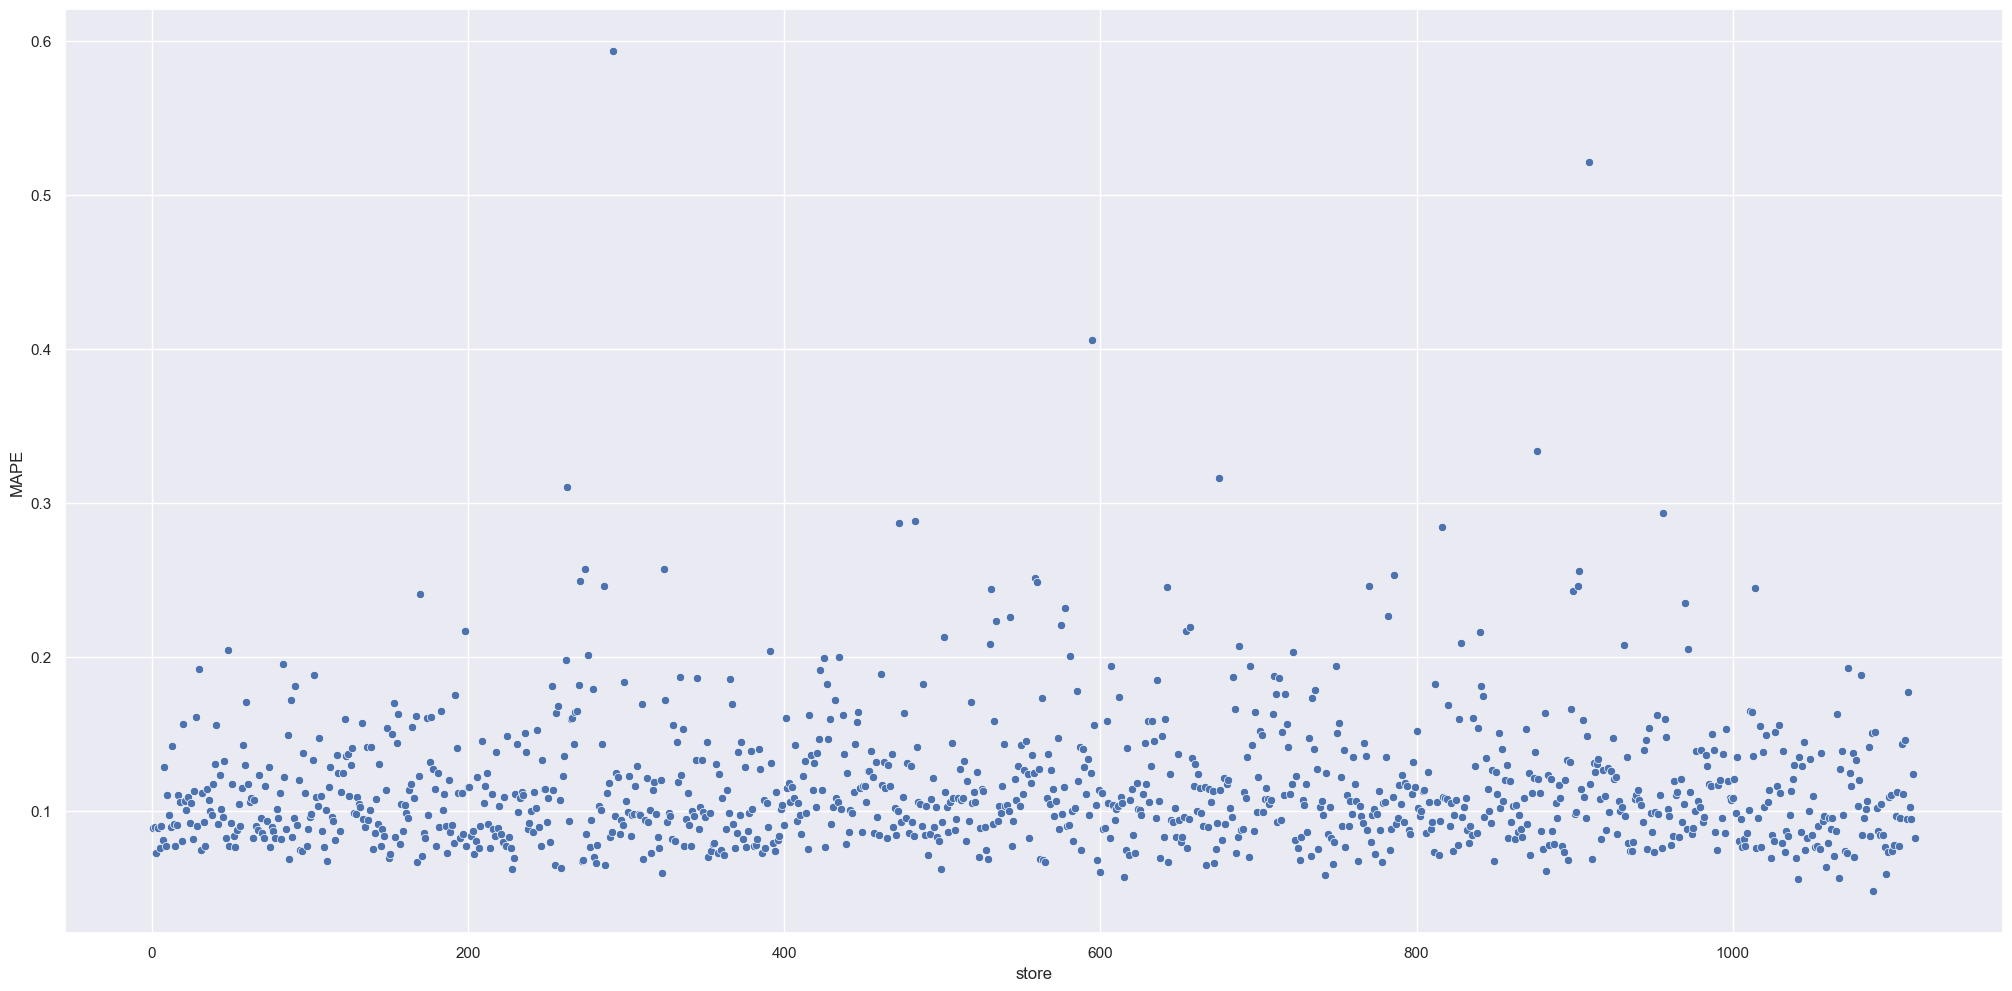

In [ ]:
sns.scatterplot(x='store',y='MAPE',data=df92)

## 9.2 TOTAL PERFORMANCE

In [ ]:
df93 = df92[['predictions', 'worst_scenario', 'best_scenario']].apply( lambda x: np.sum( x ), axis=0 ).reset_index().rename( columns={'index': 'Scenario', 0: 'Values'} )
df93['Values'] = df93['Values'].map( 'U${:,.2f}'.format )
df93

,Scenario,Values
0,predictions,"U$283,857,088.00"
1,worst_scenario,"U$282,994,540.68"
2,best_scenario,"U$284,719,621.56"


## 9.3 Machine Learning Performance

In [ ]:
df9['error'] = df9['sales'] - df9['predictions']
df9['error_rate'] = df9['predictions'] / df9['sales']

C:\Users\rseme\AppData\Local\Temp\ipykernel_21668\1385645114.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df9['error'] = df9['sales'] - df9['predictions']
C:\Users\rseme\AppData\Local\Temp\ipykernel_21668\1385645114.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df9['error_rate'] = df9['predictions'] / df9['sales']


C:\Users\rseme\AppData\Local\Temp\ipykernel_21668\1584952769.py:10: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot( df9['error'] )


<Axes: xlabel='predictions', ylabel='error'>

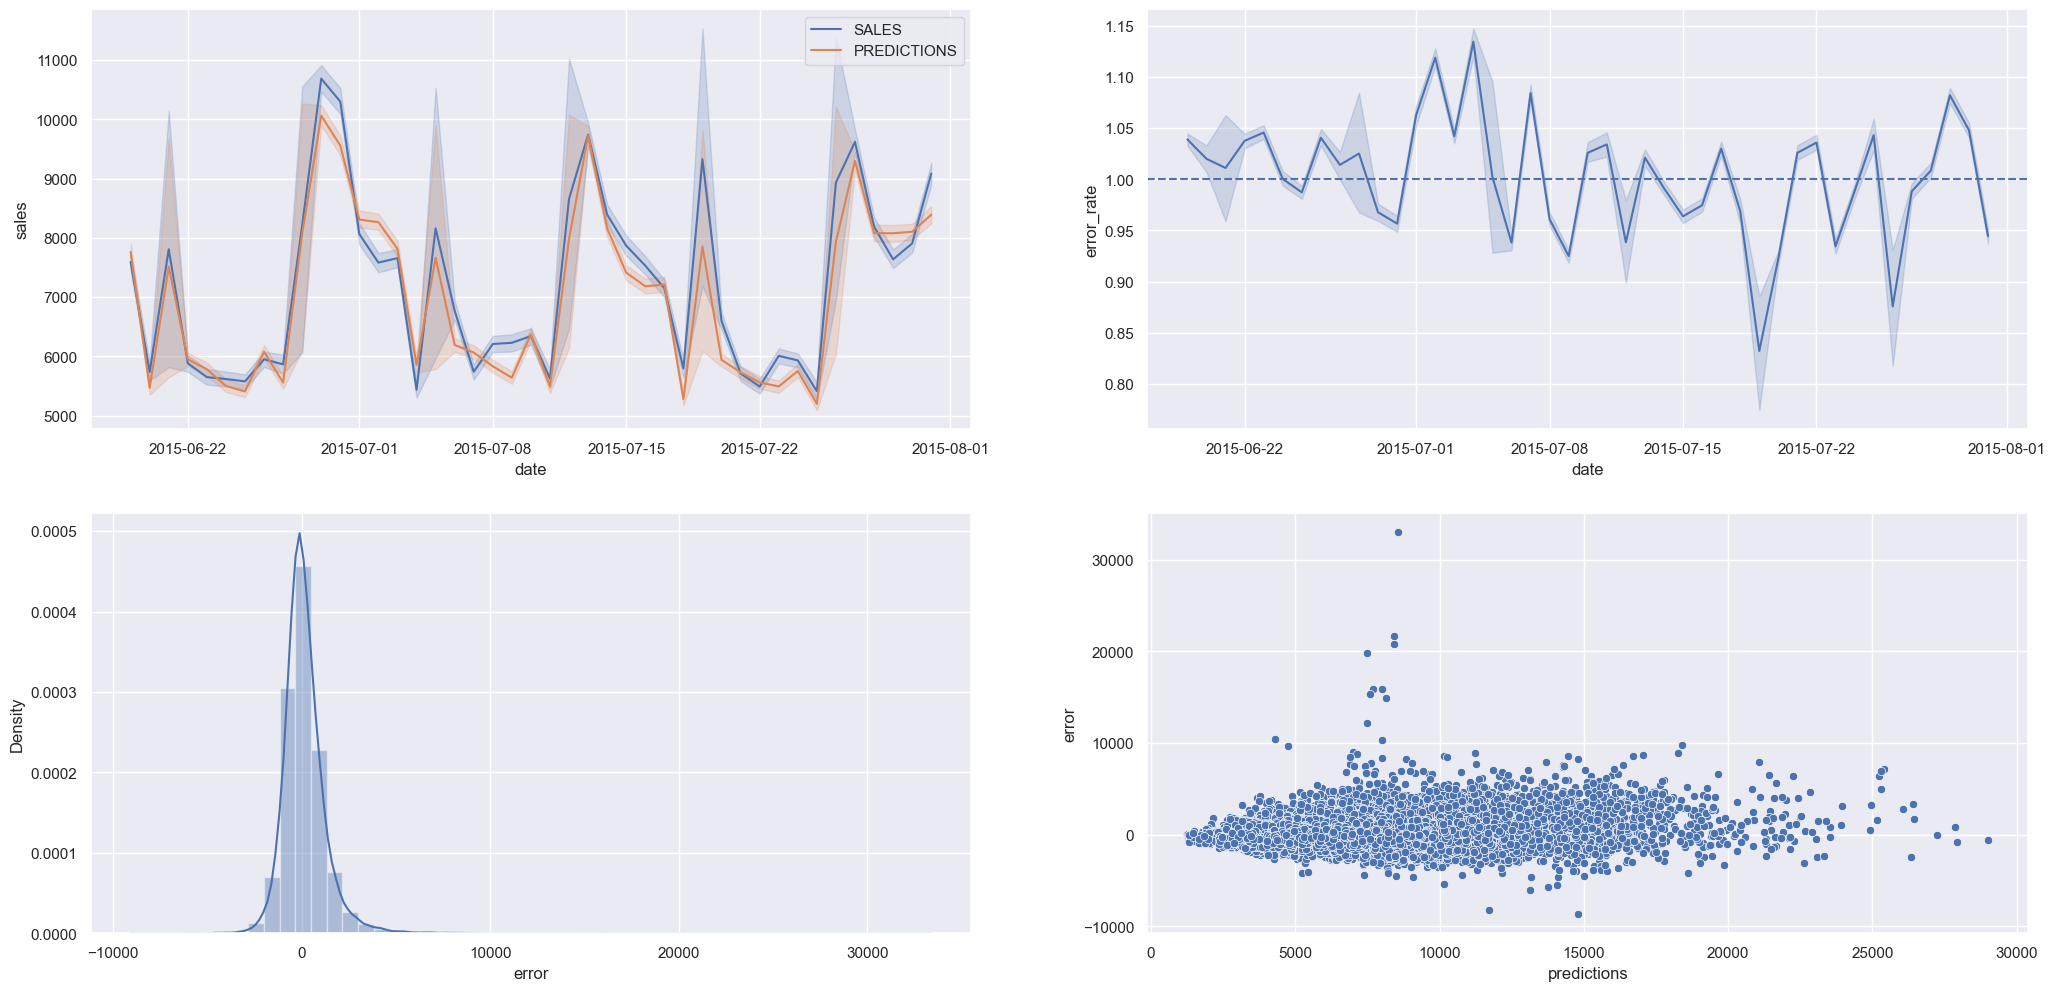

In [ ]:
plt.subplot( 2, 2, 1 )
sns.lineplot( x='date', y='sales', data=df9, label='SALES' )
sns.lineplot( x='date', y='predictions', data=df9, label='PREDICTIONS' )

plt.subplot( 2, 2, 2 )
sns.lineplot( x='date', y='error_rate', data=df9 )
plt.axhline( 1, linestyle='--')

plt.subplot( 2, 2, 3 )
sns.distplot( df9['error'] )

plt.subplot( 2, 2, 4 )
sns.scatterplot( x=df9['predictions'], y=df9['error'],data=df9 )

# 10.0 DEPLOY MODEL TO PRODUCTION

In [ ]:
pickle.dump( model_xgb_tuned, open( 'C:\\Users\\rseme\\Desktop\\projeto01\\ds_em_producao-main\\model\\model_rossmann.pkl', 'wb') )

## 10.1 Rossmann Class

In [ ]:
import pickle
import inflection
import pandas as pd
import numpy as np
import math
import datetime

class Rossmann(object):
    def __init__(self):
        self.home_path='C:\\Users\\rseme\\Desktop\\projeto01\\ds_em_producao-main\\'
        self.competition_distance_scaler   = pickle.load(open(self.home_path + 'parameter\\competition_distance_scaler.pkl', 'rb'))
        self.competition_time_month_scaler = pickle.laod(open(self.home_path + 'parameter\\competition_time_month_scaler.pkl', 'rb'))
        self.promo_time_week_scaler        = pickle.load(open(self.home_path + 'parameter\\promo_time_week_scaler.pkl', 'rb'))
        self.year_scaler                   = pickle.load(open(self.home_path + 'parameter\\year_scaler.pkl', 'rb'))
        self.store_type_scaler             = pickle.load(open(self.home_path + 'parameter\\store_type_scaler.pkl', 'rb'))

    def data_cleaning(self, df1):


        ## 1.1 Rename Columns

        cols_old = ['Store', 'DayOfWeek', 'Date', 'Open', 'Promo','StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
                  'CompetitionDistance', 'CompetitionOpenSinceMonth','CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek','Promo2SinceYear', 'PromoInterval']

        snakecase = lambda x: inflection.underscore (x)

        cols_new = list(map(snakecase, cols_old))

        #rename
        df1.columns = cols_new

        ## 1.3 Data Types
        df1['date'] = pd.to_datetime(df1['date'])

        ## 1.5 Fillout NA
        #competition_distance 
        df1['competition_distance'] = df1['competition_distance'].fillna(200000)

        #competition_open_since_month    
        df1['competition_open_since_month'] = df1['competition_open_since_month'].fillna(df1['date'].dt.month)

        #competition_open_since_year    
        df1['competition_open_since_year'] = df1['competition_open_since_year'].fillna(df1['date'].dt.year)
                                
        #promo2_since_week  
        df1['promo2_since_week'] = df1['promo2_since_week'].fillna(df1['date'].dt.isocalendar().week)

        #promo2_since_year 
        df1['promo2_since_year'] = df1['promo2_since_year'].fillna(df1['date'].dt.year)

        #promo_interval     
        month_map = {1: 'Jan', 2: 'Fev', 3:'Mar', 4:'Apr', 5:'May', 6:'Jun', 7:'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'}

        df1['promo_interval'] = df1['promo_interval'].fillna(0)

        df1['month_map'] = df1['date'].dt.month.map(month_map)

        df1['is_promo'] = df1[['promo_interval','month_map']].apply(lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split( ',' ) else 0, axis=1)
        
        ## 1.6 Change Types
        df1['competition_open_since_month'] = df1['competition_open_since_month'].astype (int)
        df1['competition_open_since_year'] = df1['competition_open_since_year'].astype (int)

        df1['promo2_since_week'] = df1['promo2_since_week'].astype (int)
        df1['promo2_since_year'] = df1['promo2_since_year'].astype (int)

        return df1
 
    def feature_engineering(self, df2):
        
        # year
        df2['year'] = df2['date'].dt.year
        # month
        df2['month'] = df2['date'].dt.month
        # day
        df2['day'] = df2['date'].dt.day
        # week of year
        df2['week_of_year'] = df2['date'].dt.isocalendar().week
        # year week
        df2['year_week'] = df2['date'].dt.strftime('%Y-%W')

        # competition since
        df2['competition_since'] = df2.apply(lambda x: datetime.datetime(year=x['competition_open_since_year'], month=x['competition_open_since_month'], day=1), axis=1)
        df2['competition_time_month'] = ((df2['date'] - df2['competition_since'])/30).apply(lambda x: x.days).astype(int)

        # promo since
        df2['promo_since'] = df2['promo2_since_year'].astype(str) + '-' + df2['promo2_since_week'].astype(str)
        df2['promo_since'] = df2['promo_since'].apply( lambda x: datetime.datetime.strptime( x + '-1', '%Y-%W-%w' ) - datetime.timedelta( days=7 ) )
        df2['promo_time_week'] = ( ( df2['date'] - df2['promo_since'] )/7 ).apply(lambda x: x.days ).astype( int )

        # assortment
        df2['assortment'] = df2['assortment'].apply( lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended' )

        # state holiday
        df2['state_holiday'] = df2['state_holiday'].apply( lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day' )

        # 3.0 FILTRAGEM DE VARIÁVEIS
        ## 3.1 Filtragem das Linhas
        df2 = df2[df2['open'] != 0 ]
        
        ## 3.2 Seleção das Colunas
        cols_drop = ['open', 'promo_interval', 'month_map']
        df2 = df2.drop(cols_drop, axis=1)
        
        return df2
    
    def data_preparation(self, df5):
    
        ## 5.2 Rescaling

        #competition distance
        df5['competition_distance'] = self.competition_distance_scaler.fit_transform(df5[['competition_distance']].values)

        #competition time month
        df5['competition_time_month'] = self.competition_time_month_scaler.fit_transform(df5[['competition_time_month']].values)
        
        #promo time week
        df5['promo_time_week'] = self.promo_time_week_scaler.fit_transform(df5[['promo_time_week']].values)
        
        #year
        df5['year'] = self.year_scaler.fit_transform(df5[['year']].values)
        
        ### 5.3.1 Encoding
        #state_holiday - one hot encoding
        df5 = pd.get_dummies(df5, prefix=['state_holiday'], columns=['state_holiday'], dtype=int)
        
        #store_type - label encoding
        df5['store_type'] = self.store_type_scaler.fit_transform(df5['store_type'])
       
        #assortment
        assortment_dict = {'basic': 1, 'extra': 2, 'extended': 3}
        df5['assortment'] = df5['assortment'].map(assortment_dict)
      
        ### 5.3.2 Nature Transformation
        # day of week
        df5['day_of_week_sin'] = df5['day_of_week'].apply( lambda x: np.sin( x * ( 2 *np.pi/7 ) ) )
        df5['day_of_week_cos'] = df5['day_of_week'].apply( lambda x: np.cos( x * ( 2 *np.pi/7 ) ) )

        # month
        df5['month_sin'] = df5['month'].apply( lambda x: np.sin( x * ( 2 * np.pi/12 )) )
        df5['month_cos'] = df5['month'].apply( lambda x: np.cos( x * ( 2 * np.pi/12 )) )

        # day
        df5['day_sin'] = df5['day'].apply( lambda x: np.sin( x * ( 2 * np.pi/30 ) ) )
        df5['day_cos'] = df5['day'].apply( lambda x: np.cos( x * ( 2 * np.pi/30 ) ) )

        # week of year
        df5['week_of_year_sin'] = df5['week_of_year'].apply( lambda x: np.sin( x * ( 2 * np.pi/52 ) ) )
        df5['week_of_year_cos'] = df5['week_of_year'].apply( lambda x: np.cos( x * ( 2 * np.pi/52 ) ) )
        
        cols_selected = [ 'store','promo','school_holiday','store_type','assortment','competition_distance',
                                'competition_open_since_month','competition_open_since_year','promo2',
                                'promo2_since_week','promo2_since_year','year','competition_time_month',
                                'promo_time_week','day_of_week_sin','day_of_week_cos','month_sin','month_cos',
                                'day_sin','day_cos', 'week_of_year_sin','week_of_year_cos']

        return df5[cols_selected]
    
    def get_prediction (self, model, original_data, test_data):
        #prediction
        pred = model.prediction(test_data)
        
        #join pred into the original data
        original_data['prediction'] = np.expm1(pred)
        
        return original_data.to_json(orient='records', date_format='iso')


## 10.2 API Handler

In [4]:
import pickle
import pandas as pd
from flask             import Flask, request, Response
from rossmann.Rossmann import Rossmann

#loading model
model = pickle.load(open('C:\\Users\\rseme\\Desktop\\projeto01\\ds_em_producao-main\\model\\model_rossmann.pkl', 'rb'))

#iniatialize API
app = Flask(__name__)

@app.route('/rossmann/predict', methods=['POST'])

def rossmann_predict():
        test_json = request.get_json()
        
        if test_json: #there is data
                if isinstance(test_json, dict): #unique exemple
                    test_raw = pd.DataFrame(test_json, index=[0])
                    
                else: #multiple example
                    test_raw = pd.DataFrame(test_json, columns=test_json[0].keys())
                    
                #Instantiate Rossmann Class
                pipeline = Rossmann()
                
                #data cleaning
                df1 = pipeline.data_cleaning(test_raw)
                
                #feature engineering
                df2 = pipeline.feature_engineering(df1)
                
                #data preparation
                df3 = pipeline.data_preparation (df2)
                
                #prediction
                df_response = pipeline.get_prediction(model, test_raw, df3)
                
                return df_response
        
        else:
                return Response('{}',status=200, mimetype='application/json')

if __name__ == '__main__':
        app.run('0.0.0.0')

 * Serving Flask app '__main__'
 * Debug mode: off


 * Running on all addresses (0.0.0.0)
 * Running on http://127.0.0.1:5000
 * Running on http://192.168.15.5:5000
Press CTRL+C to quit


## 10.3 API Tester

In [5]:
import json
import requests

In [6]:
#loading teste dataset
df10 = pd.read_csv('data/test.csv')

In [7]:
# merge test dataset + store
df_test = pd.merge(df10, df_store_raw, how='left', on='Store')

# choose store for prediction
df_test = df_test[df_test['Store'].isin([3,7,10,12,145,345,879]) ]

#remove closed days
df_test = df_test[df_test['Open'] !=0  ]
df_test = df_test[~df_test['Open'].isnull()]
df_test = df_test.drop("Id", axis=1)

In [13]:
# Convertendo DataFrame para JSON
data = json.dumps(df_test.to_dict(orient='records'))

url = 'https://rossmann-model-test-wogg.onrender.com/rossmann/predict'  # URL correta da API

# Cabeçalho da solicitação
header = {'Content-type': 'application/json'}

# Enviar a solicitação
r = requests.post(url, data=data, headers=header)  # Corrigindo para usar rl em vez de url e passando dados como JSON

# Verificar o status code da resposta
print('Status Code:', r.status_code)

Status Code: 200


In [10]:
d1 = pd.DataFrame( r.json(), columns=r.json()[0].keys() )

In [11]:
d1.head(10)

,store,day_of_week,date,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,...,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week,prediction
0,3,4,2015-09-17T00:00:00.000,1.0,1,regular_day,0,a,basic,14130.0,...,2015,9,17,38,2015-37,2006-12-01T00:00:00.000,107,2011-03-28T00:00:00.000,233,6027.181641
1,7,4,2015-09-17T00:00:00.000,1.0,1,regular_day,0,a,extended,24000.0,...,2015,9,17,38,2015-37,2013-04-01T00:00:00.000,29,2015-09-14T00:00:00.000,0,8442.224609
2,10,4,2015-09-17T00:00:00.000,1.0,1,regular_day,0,a,basic,3160.0,...,2015,9,17,38,2015-37,2009-09-01T00:00:00.000,73,2015-09-14T00:00:00.000,0,6139.895508
3,12,4,2015-09-17T00:00:00.000,1.0,1,regular_day,0,a,extended,1070.0,...,2015,9,17,38,2015-37,2015-09-01T00:00:00.000,0,2010-03-22T00:00:00.000,286,7811.080566
4,145,4,2015-09-17T00:00:00.000,1.0,1,regular_day,0,a,basic,280.0,...,2015,9,17,38,2015-37,2015-09-01T00:00:00.000,0,2009-11-02T00:00:00.000,306,6239.968262
5,3,3,2015-09-16T00:00:00.000,1.0,1,regular_day,0,a,basic,14130.0,...,2015,9,16,38,2015-37,2006-12-01T00:00:00.000,107,2011-03-28T00:00:00.000,233,6124.564941
6,7,3,2015-09-16T00:00:00.000,1.0,1,regular_day,0,a,extended,24000.0,...,2015,9,16,38,2015-37,2013-04-01T00:00:00.000,29,2015-09-14T00:00:00.000,0,8541.539062
7,10,3,2015-09-16T00:00:00.000,1.0,1,regular_day,0,a,basic,3160.0,...,2015,9,16,38,2015-37,2009-09-01T00:00:00.000,73,2015-09-14T00:00:00.000,0,6272.089844
8,12,3,2015-09-16T00:00:00.000,1.0,1,regular_day,0,a,extended,1070.0,...,2015,9,16,38,2015-37,2015-09-01T00:00:00.000,0,2010-03-22T00:00:00.000,286,7928.905762
9,145,3,2015-09-16T00:00:00.000,1.0,1,regular_day,0,a,basic,280.0,...,2015,9,16,38,2015-37,2015-09-01T00:00:00.000,0,2009-11-02T00:00:00.000,306,6336.417969


In [11]:
d2 = d1[['store', 'prediction']].groupby('store').sum().reset_index()

for i in range( len( d2 ) ):
        print( 'Store Number {} will sell R${:,.2f} in the next 6 weeks'.format(d2.loc[i, 'store'],d2.loc[i, 'prediction'] ) )
        

Store Number 3 will sell R$216,696.17 in the next 6 weeks
Store Number 7 will sell R$306,953.05 in the next 6 weeks
Store Number 10 will sell R$238,477.29 in the next 6 weeks
Store Number 12 will sell R$245,726.68 in the next 6 weeks
Store Number 145 will sell R$206,262.83 in the next 6 weeks
Store Number 345 will sell R$176,118.42 in the next 6 weeks
Store Number 879 will sell R$160,118.42 in the next 6 weeks
